In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft, scf, gto, cc
from pyscfad import dft as dft_ad
from pyscfad import gto as gto_ad
from functools import partial
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp
jax.config.update("jax_enable_x64", True) #Enables 64 bit precision


from xcquinox import net
from xcquinox.loss import compute_loss_mae
from xcquinox.train import Pretrainer
from xcquinox.utils import gen_grid_s, PBE_Fx, PBE_Fc, calculate_stats, lda_x, pw92c_unpolarized

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:773: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# Pre-training PBE Networks

In [2]:
#network structure
pbe_fx = net.GGA_FxNet_s(depth=3, nodes=16, seed=92017)
pbe_fc = net.GGA_FcNet_s(depth=3, nodes=16, seed=92017)

In [3]:
#sigma-based networks
spbe_fx = net.GGA_FxNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)
spbe_fc = net.GGA_FcNet_sigma(depth=3, nodes=16, seed=92017, lower_rho_cutoff = 0)

In [4]:
#training and validation values
inds, vals, tflats, vflats = gen_grid_s(npts = 1e5)
train_inds, val_inds = inds
rv, grv, sv = vals
trf, tgrf, tsf = tflats
vrf, vgrf, vsf = vflats
#training and validation values for SIGMA
sinds, svals, stflats, svflats = gen_grid_s(npts = 1e5, sigma=True)
strain_inds, sval_inds = sinds
srv, sgrv, ssv = svals
strf, stgrf, stsf = stflats
svrf, svgrf, svsf = svflats

shapes- r/gr/s: (315,)/(315,)/(315,)
shapes- r/gr/s: (315,)/(315,)/(315,)


In [104]:
315**2, 0.8*315**2, 0.2*315**2

(99225, 79380.0, 19845.0)

In [5]:
train_inds, val_inds, strain_inds, sval_inds

(array([ 66, 313, 221, 275,  14, 310, 180, 165,  27, 225, 179, 132,  58,
        161,  35, 284,  21, 119, 229,  93, 257,  92, 176, 301, 308, 163,
         60, 297, 167, 208, 236, 187, 147, 237, 261, 197,  54,  99, 302,
        171, 259, 246, 295, 233,   1, 129,  64,  67, 252, 224, 256, 130,
        207, 299, 160, 191,  98, 203,  73, 182, 181, 103, 292,  23,  34,
        234,  10,   9, 298, 212, 113,   7, 290,  25, 110, 131,  96, 186,
         40, 122, 291, 286, 100, 107,  95,  65,  75, 138, 140, 210,  36,
         89,  47, 250, 108, 312, 231, 139,  62,  15,  28, 296,  79,  59,
        133, 293, 185, 251, 314,  33, 240, 195,   8,  45, 204, 311, 175,
        274, 153,  91,  84,  85, 159, 137, 166, 276, 104, 192,  81,  49,
        193, 199, 222, 217, 190, 279, 105, 198, 121, 173, 143, 235, 155,
         12, 128, 305,  22,  38,  17,  26,  71,   6, 232, 282, 307,  82,
        244, 281, 215,  52,  87,  63, 188, 118, 219,  32, 243,  19, 184,
        280, 125,  74, 238, 169, 120, 111, 154, 177

In [105]:
train_inds.shape, val_inds.shape, strain_inds.shape, sval_inds.shape

((253,), (62,), (253,), (62,))

In [107]:
253**2, 62**2, 253**2 + 62**2, 

(64009, 3844, 67853)

In [6]:
ref_fx = PBE_Fx(trf, tgrf)
ref_fc = PBE_Fc(trf, tgrf)

sinputs = jnp.stack([trf, tsf], axis=1)
siginputs = jnp.stack([strf, stgrf], axis=1)
sval = jnp.stack([vrf, vsf], axis=1)
print(sval.shape, sinputs.shape)

(3844, 2) (64009, 2)


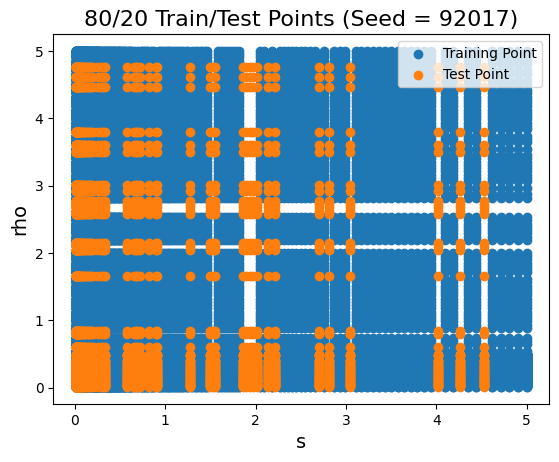

In [75]:
plt.scatter(trf, tsf, label='Training Point')
plt.scatter(vrf, vsf, label='Test Point')
plt.ylabel('rho', fontsize=14)
plt.xlabel('s', fontsize=14)
plt.title('80/20 Train/Test Points (Seed = 92017)', fontsize=16)
plt.legend()

In [8]:
#create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-4)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)

In [9]:
pt_pbe_fx = Pretrainer(model = pbe_fx, optim = optimizer_fx, inputs = sinputs, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
pt_pbe_fc = Pretrainer(model = pbe_fc, optim = optimizer_fc, inputs = sinputs, ref = ref_fc, loss = compute_loss_mae, steps = 2500)

In [10]:
nmx, nlx = pt_pbe_fx()
nmc, nlc = pt_pbe_fc()

Epoch 0: Loss = 0.12663097651184216
Epoch 100: Loss = 0.09844872335327282
Epoch 200: Loss = 0.06325872688253248
Epoch 300: Loss = 0.022543970055829095
Epoch 400: Loss = 0.0035225629675758874
Epoch 500: Loss = 0.002974922958551258
Epoch 600: Loss = 0.0024582211538656203
Epoch 700: Loss = 0.0019585930070951394
Epoch 800: Loss = 0.0014636003892057594
Epoch 900: Loss = 0.0010763426445123403
Epoch 1000: Loss = 0.0008263259660462232
Epoch 1100: Loss = 0.000626140636807112
Epoch 1200: Loss = 0.00039735972843363656
Epoch 1300: Loss = 0.000302643497868761
Epoch 1400: Loss = 0.00026677924538162087
Epoch 1500: Loss = 0.00024065298366670603
Epoch 1600: Loss = 0.00021165557582128637
Epoch 1700: Loss = 0.00018650099396847573
Epoch 1800: Loss = 0.0001644083635662091
Epoch 1900: Loss = 0.0001454986512011504
Epoch 2000: Loss = 0.00012810420205962292
Epoch 2100: Loss = 0.00011246143438366865
Epoch 2200: Loss = 9.902745389103789e-05
Epoch 2300: Loss = 8.773345212590733e-05
Epoch 2400: Loss = 7.7296794904

In [11]:
#create optimizers
soptimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
soptimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)
spt_pbe_fx = Pretrainer(model = spbe_fx, optim = soptimizer_fx, inputs = siginputs, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
spt_pbe_fc = Pretrainer(model = spbe_fc, optim = soptimizer_fc, inputs = siginputs, ref = ref_fc, loss = compute_loss_mae, steps = 2500)

In [12]:
snmx, snlx = spt_pbe_fx()
snmc, snlc = spt_pbe_fc()

Epoch 0: Loss = 0.12663097651184216
Epoch 100: Loss = 0.0017671856564952524
Epoch 200: Loss = 0.0003965925629766831
Epoch 300: Loss = 0.00028912330522684355
Epoch 400: Loss = 0.00016220979333161052
Epoch 500: Loss = 0.0004153561510694676
Epoch 600: Loss = 0.00030480704476936664
Epoch 700: Loss = 0.00017691502797180086
Epoch 800: Loss = 8.416372507587885e-05
Epoch 900: Loss = 0.00042248722558041045
Epoch 1000: Loss = 0.00011889105515791767
Epoch 1100: Loss = 7.404514466940142e-05
Epoch 1200: Loss = 0.00028129127463337683
Epoch 1300: Loss = 0.0005135179035251493
Epoch 1400: Loss = 0.00010445190975950489
Epoch 1500: Loss = 0.0003308283695001772
Epoch 1600: Loss = 7.517391726978416e-05
Epoch 1700: Loss = 0.0003138221200721154
Epoch 1800: Loss = 0.0007098194925602726
Epoch 1900: Loss = 0.00042569768777572233
Epoch 2000: Loss = 0.0002733275062483321
Epoch 2100: Loss = 0.0003532146246426234
Epoch 2200: Loss = 0.00038587617481429363
Epoch 2300: Loss = 0.00021954711246016719
Epoch 2400: Loss = 

To demonstrate how critical the choice of training data is, see below.

shapes- r/gr/s: (315,)/(315,)/(315,)


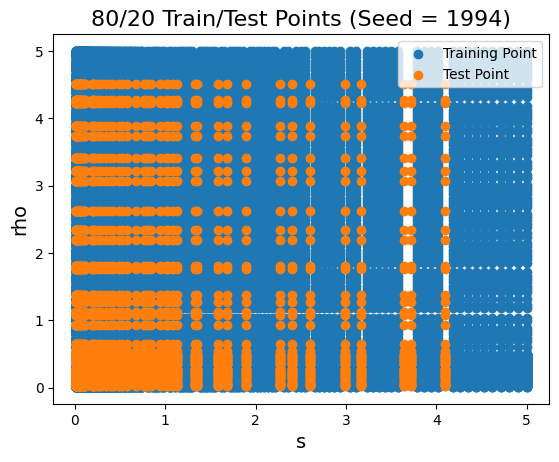

In [78]:
sinds2, svals2, stflats2, svflats2 = gen_grid_s(npts = 1e5, sigma=True, ranseed=1994)
strain_inds2, sval_inds2 = sinds2
srv2, sgrv2, ssv2 = svals2
strf2, stgrf2, stsf2 = stflats2
svrf2, svgrf2, svsf2 = svflats2

plt.scatter(strf2, stsf2, label='Training Point')
plt.scatter(svrf2, svsf2, label='Test Point')
plt.ylabel('rho', fontsize=14)
plt.xlabel('s', fontsize=14)
plt.title('80/20 Train/Test Points (Seed = 1994)', fontsize=16)
plt.legend()
siginputs2 = jnp.stack([strf2, stgrf2], axis=1)
soptimizer_fx2 = optax.chain(
    optax.adam(learning_rate=1e-3)
)
soptimizer_fc2 = optax.chain(
    optax.adam(learning_rate=1e-3)
)

spt_pbe_fx2 = Pretrainer(model = spbe_fx, optim = soptimizer_fx2, inputs = siginputs2, ref = ref_fx, loss = compute_loss_mae, steps = 2500)
spt_pbe_fc2 = Pretrainer(model = spbe_fc, optim = soptimizer_fc2, inputs = siginputs2, ref = ref_fc, loss = compute_loss_mae, steps = 2500)

In [14]:
snmx2, snlx2 = spt_pbe_fx2()
snmc2, snlc2 = spt_pbe_fc2()

Epoch 0: Loss = 0.15719585433885377
Epoch 100: Loss = 0.1471939219025453
Epoch 200: Loss = 0.1458719625419891
Epoch 300: Loss = 0.14467193818685717
Epoch 400: Loss = 0.14342436379506177
Epoch 500: Loss = 0.14251454587287826
Epoch 600: Loss = 0.1423987866810566
Epoch 700: Loss = 0.14235073217224817
Epoch 800: Loss = 0.14227861847362414
Epoch 900: Loss = 0.1423196958528732
Epoch 1000: Loss = 0.14215930456792247
Epoch 1100: Loss = 0.14204863084219513
Epoch 1200: Loss = 0.14191672629097893
Epoch 1300: Loss = 0.1417119547477477
Epoch 1400: Loss = 0.14153251009256582
Epoch 1500: Loss = 0.14140904031946502
Epoch 1600: Loss = 0.14131164223683304
Epoch 1700: Loss = 0.14124131090245085
Epoch 1800: Loss = 0.14119546078797843
Epoch 1900: Loss = 0.14117022289583925
Epoch 2000: Loss = 0.14113800595372528
Epoch 2100: Loss = 0.14112222670838023
Epoch 2200: Loss = 0.14107908493607504
Epoch 2300: Loss = 0.14105163100034504
Epoch 2400: Loss = 0.1410433347985291
Epoch 0: Loss = 0.3633249047965794
Epoch 10

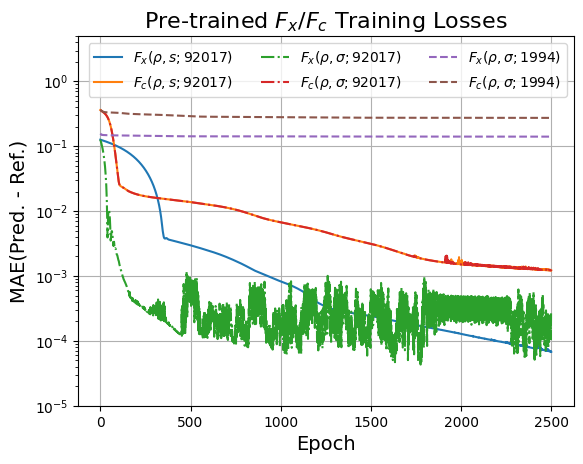

In [83]:
plt.plot(nlx, label='$F_x(\\rho,s;92017)$')
plt.plot(nlc, label='$F_c(\\rho,s;92017)$')
plt.plot(snlx, '-.', label='$F_x(\\rho,\\sigma;92017)$')
plt.plot(snlc, '-.', label='$F_c(\\rho,\\sigma;92017)$')
plt.plot(snlx2, '--', label='$F_x(\\rho,\\sigma;1994)$')
plt.plot(snlc2, '--', label='$F_c(\\rho,\\sigma;1994)$')
plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylim(1e-5, 5e0)
plt.ylabel('MAE(Pred. - Ref.)', fontsize=14)
plt.title('Pre-trained $F_x$/$F_c$ Training Losses', fontsize=16)
plt.grid()
plt.legend(ncol=3)

In [16]:
siginputs.mean(axis=0), siginputs2.mean(axis=0)

(Array([  0.8072265 , 498.49542592], dtype=float64),
 Array([  0.82000703, 538.18504421], dtype=float64))

So the training selection evidently has a **huge** impact on the resulting network accuracy.

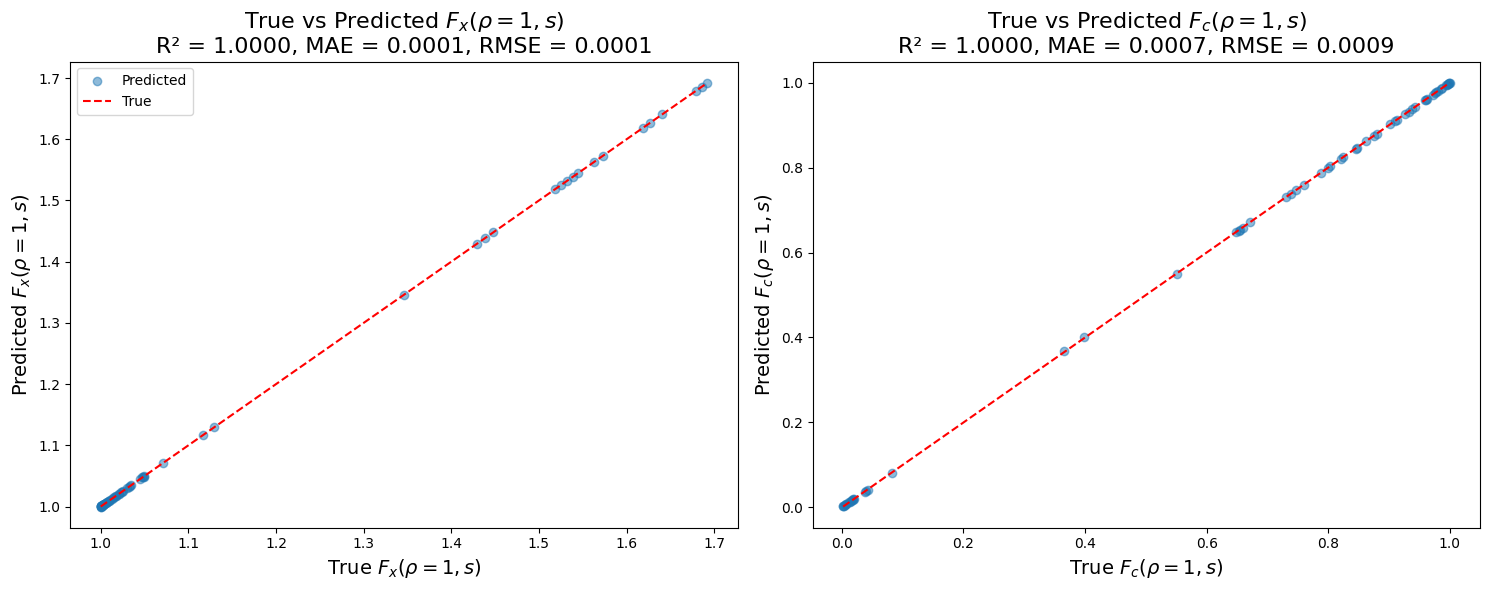

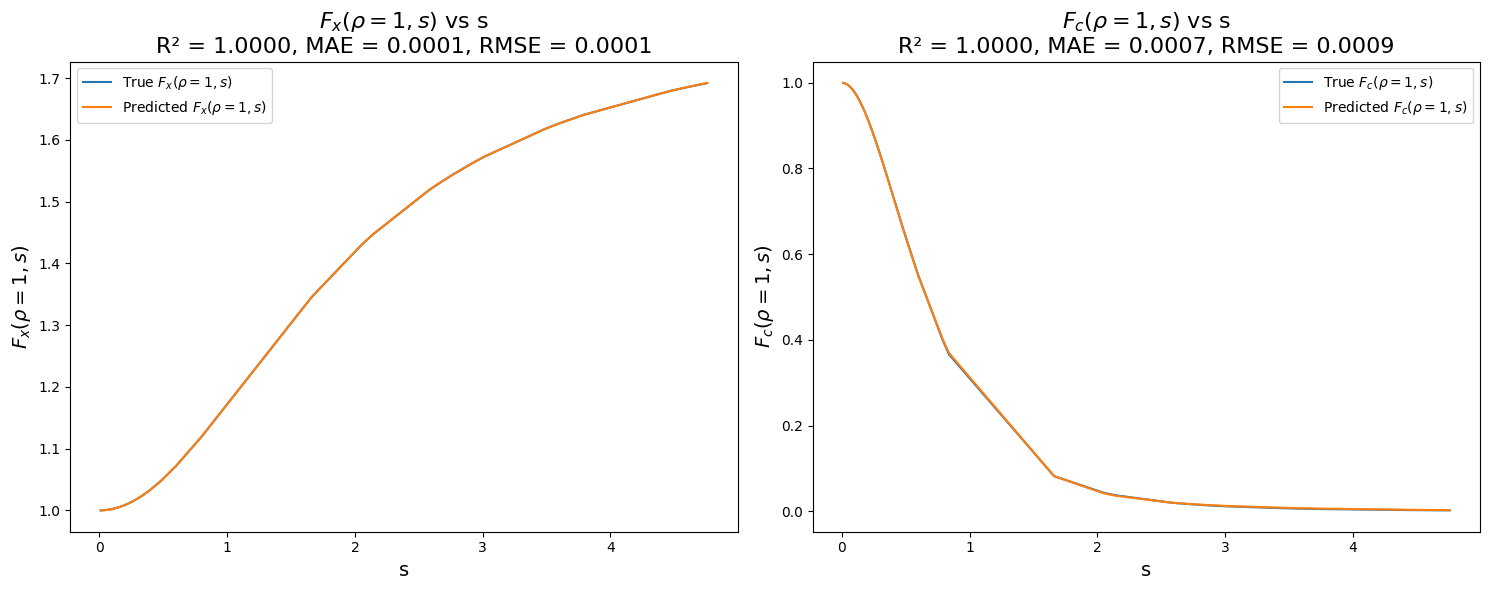

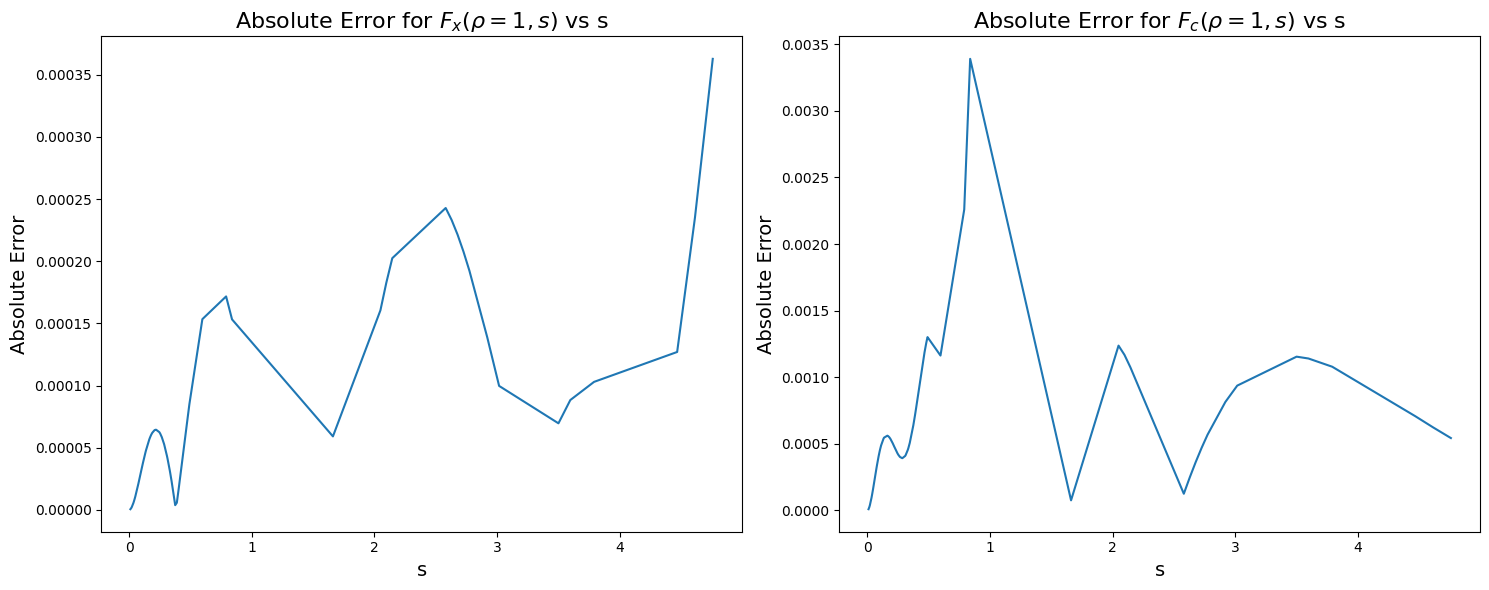

Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000082
Root Mean Squared Error: 0.000111
Maximum Absolute Error: 0.000363

Fc Statistics:
R-squared: 0.999995
Mean Absolute Error: 0.000663
Root Mean Squared Error: 0.000854
Maximum Absolute Error: 0.003390


In [88]:
#for simplicity, we assume constant rho=1 for this test case and use the validation s; the 2d case will show the validation set using both
test_s = jnp.array(sorted(sv[val_inds]))
# test_rho = jnp.full_like(test_s, rv[val_inds].min())
test_rho = jnp.full_like(test_s, 1.0)
test_1d = jnp.stack([test_rho, test_s], axis=1)
# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Calculate true PBE enhancement factors
true_fx_test = PBE_Fx(test_rho, grad_rho_test)
true_fc_test = PBE_Fc(test_rho, grad_rho_test)

pred_fx = jax.vmap(nmx)(test_1d)
pred_fc = jax.vmap(nmc)(test_1d)

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)
# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5, label='Predicted')
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--', label='True')
ax1.set_xlabel('True $F_x(\\rho=1, s)$', fontsize=14)
ax1.set_ylabel('Predicted $F_x(\\rho=1, s)$', fontsize=14)
ax1.set_title(f'True vs Predicted $F_x(\\rho=1, s)$\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}', fontsize=16)
ax1.legend()

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True $F_c(\\rho=1, s)$', fontsize=14)
ax2.set_ylabel('Predicted $F_c(\\rho=1, s)$', fontsize=14)
ax2.set_title(f'True vs Predicted $F_c(\\rho=1, s)$\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}', fontsize=16)

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True $F_x(\\rho=1, s)$')
ax1.plot(test_s, pred_fx, label='Predicted $F_x(\\rho=1, s)$')
ax1.set_xlabel('s', fontsize=14)
ax1.set_ylabel('$F_x(\\rho=1, s)$', fontsize=14)
ax1.set_title(f'$F_x(\\rho=1, s)$ vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}', fontsize=16)
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True $F_c(\\rho=1, s)$')
ax2.plot(test_s, pred_fc, label='Predicted $F_c(\\rho=1, s)$')
ax2.set_xlabel('s', fontsize=14)
ax2.set_ylabel('$F_c(\\rho=1, s)$', fontsize=14)
ax2.set_title(f'$F_c(\\rho=1, s)$ vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}', fontsize=16)
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s', fontsize=14)
ax1.set_ylabel('Absolute Error', fontsize=14)
ax1.set_title('Absolute Error for $F_x(\\rho=1, s)$ vs s', fontsize=16)

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s', fontsize=14)
ax2.set_ylabel('Absolute Error', fontsize=14)
ax2.set_title('Absolute Error for $F_c(\\rho=1, s)$ vs s', fontsize=16)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

In [92]:
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()], interpolation='none')
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    # ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    # ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', 
                     extent=[rho_values.min(), rho_values.max(), s_values.min(), s_values.max()])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    # ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
def plot_contour(true, pred, title, rho_values, s_values, ylog=True, cmap='inferno', pred_vminmax = None, true_vminmax = None, levels=25, ncbarticks=5, coffset = 1e-4):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    if true_vminmax:
        print('Custom vmin/vmax set -- reading.')
        tvmin, tvmax = true_vminmax
    else:
        tvmin = round(true.min(), 1)
        tvmax = round(true.max(), 1)
    print('Contour: true values - vmin/vmax = {}/{}'.format(tvmin, tvmax))
    im1 = ax1.contourf(s_values, rho_values, true, cmap=cmap, vmin = tvmin-coffset, vmax = tvmax+coffset, levels=np.linspace(tvmin, tvmax, levels, endpoint=True))
    im1.set_clim(vmin=true.min(), vmax=true.max())
    ax1.set_title(f'True {title}', fontsize=16)
    ax1.set_xlabel('$s$', fontsize=14)
    ax1.set_ylabel('$\\rho$', fontsize=14)
    cbar1 = fig.colorbar(im1, ax=ax1, ticks=np.linspace(tvmin, tvmax, num=ncbarticks, endpoint=True))
    
    if pred_vminmax:
        print('Custom vmin/vmax set -- reading.')
        pvmin, pvmax = pred_vminmax
    else:
        pvmin = round(pred.min(), 1)
        pvmax = round(pred.max(), 1)
    print('Contour: pred values - vmin/vmax = {}/{}'.format(pvmin,  pvmax))
    im2 = ax2.contourf(s_values, rho_values, pred, cmap=cmap, vmin = pvmin-coffset, vmax = pvmax+coffset, levels=np.linspace(pvmin, pvmax, levels, endpoint=True))
    ax2.set_title(f'Predicted {title}', fontsize=16)
    ax2.set_xlabel('$s$', fontsize=14)
    ax2.set_ylabel('$\\rho$', fontsize=14)
    cbar2 = fig.colorbar(im2, ax=ax2, ticks=np.linspace(pvmin, pvmax, num=ncbarticks, endpoint=True))
    cbar2.ax.get_yaxis().set_ticks(np.linspace(tvmin, tvmax, num=ncbarticks, endpoint=True)) 
    
    error = np.abs(true - pred)
    print('Contour: error values - vmin/vmax = {}/{}'.format(error.min(), error.max()))
    im3 = ax3.contourf(s_values, rho_values, error, cmap=cmap, vmin = error.min(), vmax = error.max(), levels=np.linspace(error.min(), error.max(), levels, endpoint=True))
    ax3.set_title(f'Absolute Error for {title}', fontsize=16)
    ax3.set_xlabel('$s$', fontsize=14)
    ax3.set_ylabel('$\\rho$', fontsize=14)
    cbar3 = fig.colorbar(im3, ax=ax3, ticks=np.linspace(error.min(), error.max(), num=ncbarticks, endpoint=True))
    # im3.set_clim(vmin=error.min(), vmax=error.max())
    
    if ylog:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
        ax3.set_yscale('log')

    plt.tight_layout()
    plt.show()


Fx Statistics:
R-squared: 1.000000
Mean Absolute Error: 0.000082
Root Mean Squared Error: 0.000111
Maximum Absolute Error: 0.000363

Fc Statistics:
R-squared: 0.999964
Mean Absolute Error: 0.001229
Root Mean Squared Error: 0.002373
Maximum Absolute Error: 0.020952
Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 1/1.7
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 1/1.7
Contour: error values - vmin/vmax = 5.265746287896889e-07/0.0003627984044443089


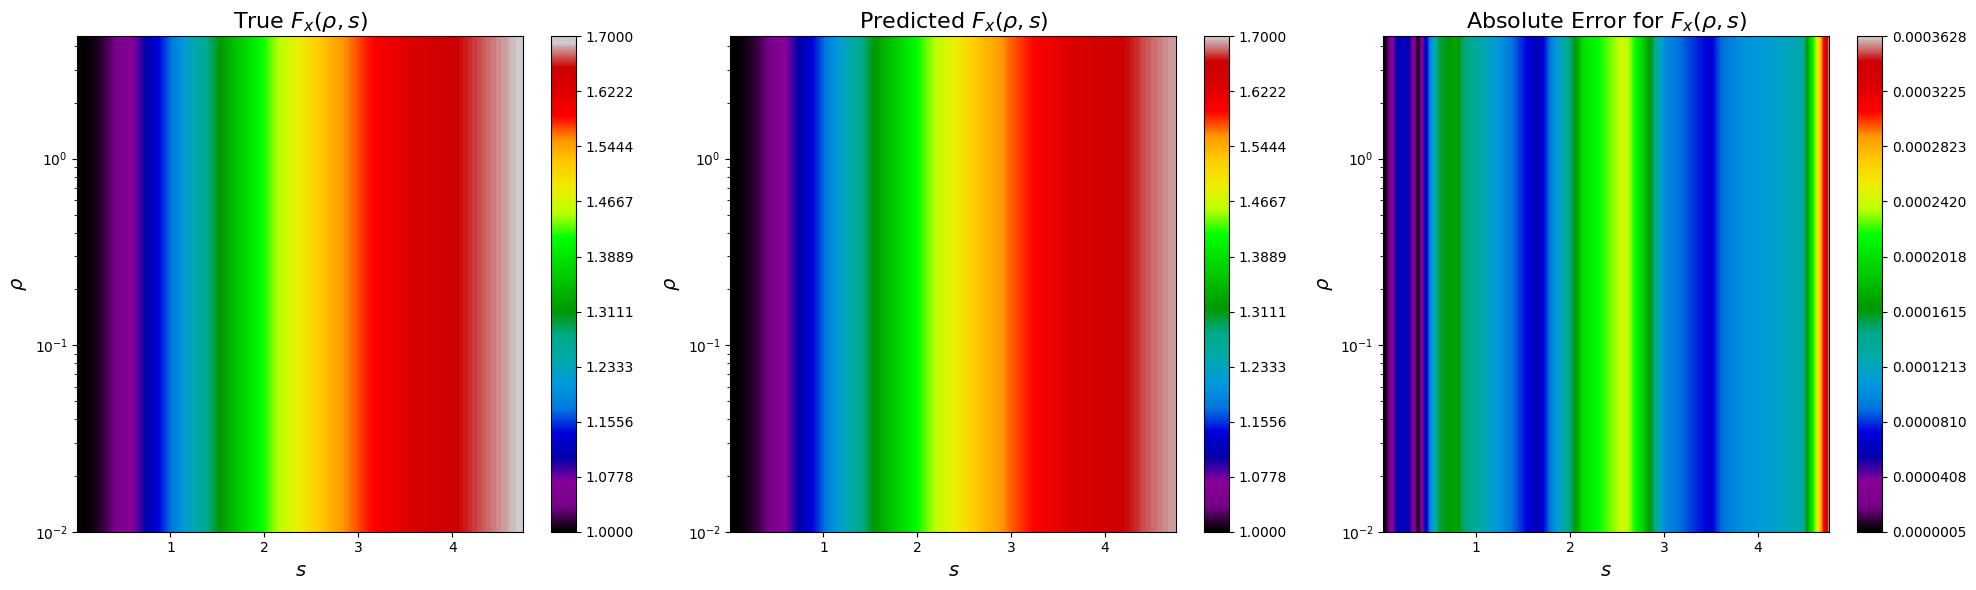

Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 0/1.0
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 0/1.0
Contour: error values - vmin/vmax = 1.5889167193083864e-07/0.020951668722660965


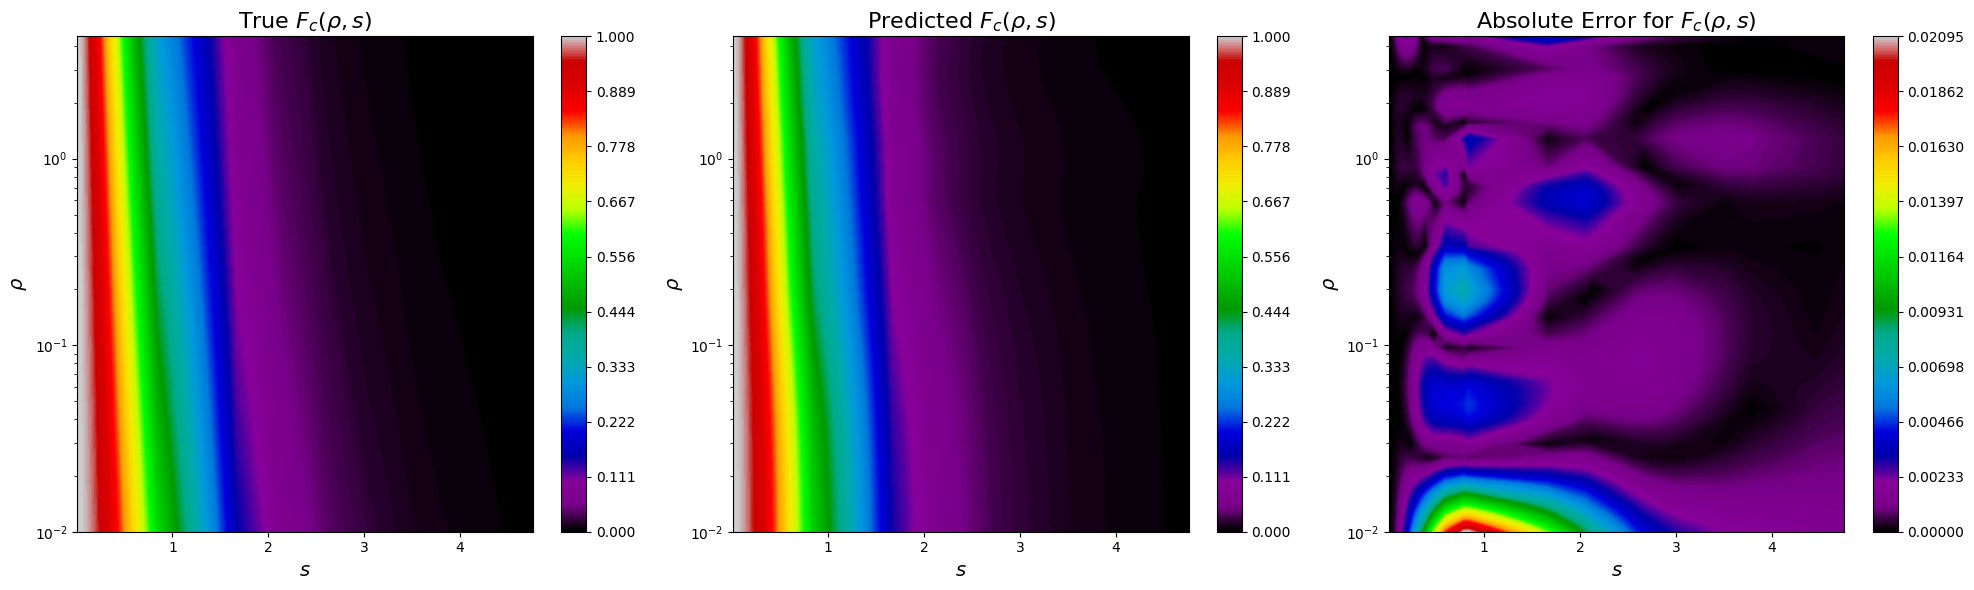

In [109]:
test_s = jnp.array(sorted(sv[val_inds]))
test_rho = jnp.array(sorted(rv[val_inds]))

NUM_S = len(test_s)
NUM_RHO = len(test_rho)

s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
img_sinps = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)

true_fx_test = PBE_Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = PBE_Fc(rho_mesh.flatten(), grad_rho_test.flatten())

pred_fx = jax.vmap(nmx)(img_sinps)
pred_fc = jax.vmap(nmc)(img_sinps)

RSLEN = len(val_inds)

true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

ir2_fx, imae_fx, irmse_fx, maxex = calculate_stats(true_fx_test, pred_fx)
ir2_fc, imae_fc, irmse_fc, maxec = calculate_stats(true_fc_test, pred_fc)
# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {ir2_fx:.6f}")
print(f"Mean Absolute Error: {imae_fx:.6f}")
print(f"Root Mean Squared Error: {irmse_fx:.6f}")
print(f"Maximum Absolute Error: {maxex:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {ir2_fc:.6f}")
print(f"Mean Absolute Error: {imae_fc:.6f}")
print(f"Root Mean Squared Error: {irmse_fc:.6f}")
print(f"Maximum Absolute Error: {maxec:.6f}")
plot_contour(true_fx_test, pred_fx, '$F_x(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (1, 1.7), true_vminmax = (1, 1.7), levels=500, ncbarticks = 10, coffset=0)
plot_contour(true_fc_test, pred_fc, '$F_c(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (0, 1.0), true_vminmax = (0, 1.0), levels=500, ncbarticks = 10)


Fx Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000144
Root Mean Squared Error: 0.000280
Maximum Absolute Error: 0.000732

Fc Statistics:
R-squared: 0.999962
Mean Absolute Error: 0.001280
Root Mean Squared Error: 0.002439
Maximum Absolute Error: 0.021403
Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 1/1.7
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 1/1.7
Contour: error values - vmin/vmax = 1.6416778247929642e-07/0.000731582447249135


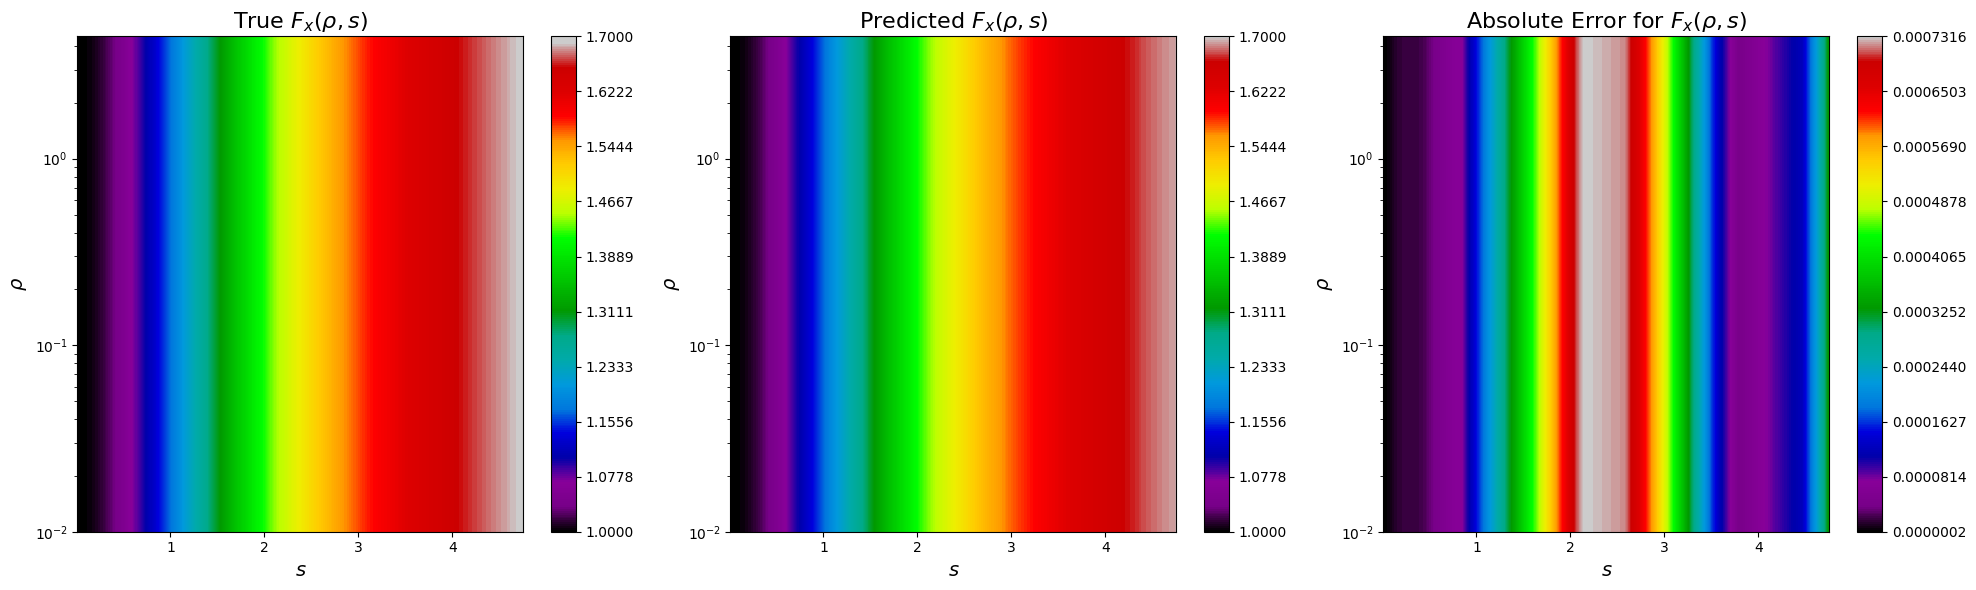

Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 0/1.0
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 0/1.0
Contour: error values - vmin/vmax = 5.66123326217749e-07/0.021403437582869222


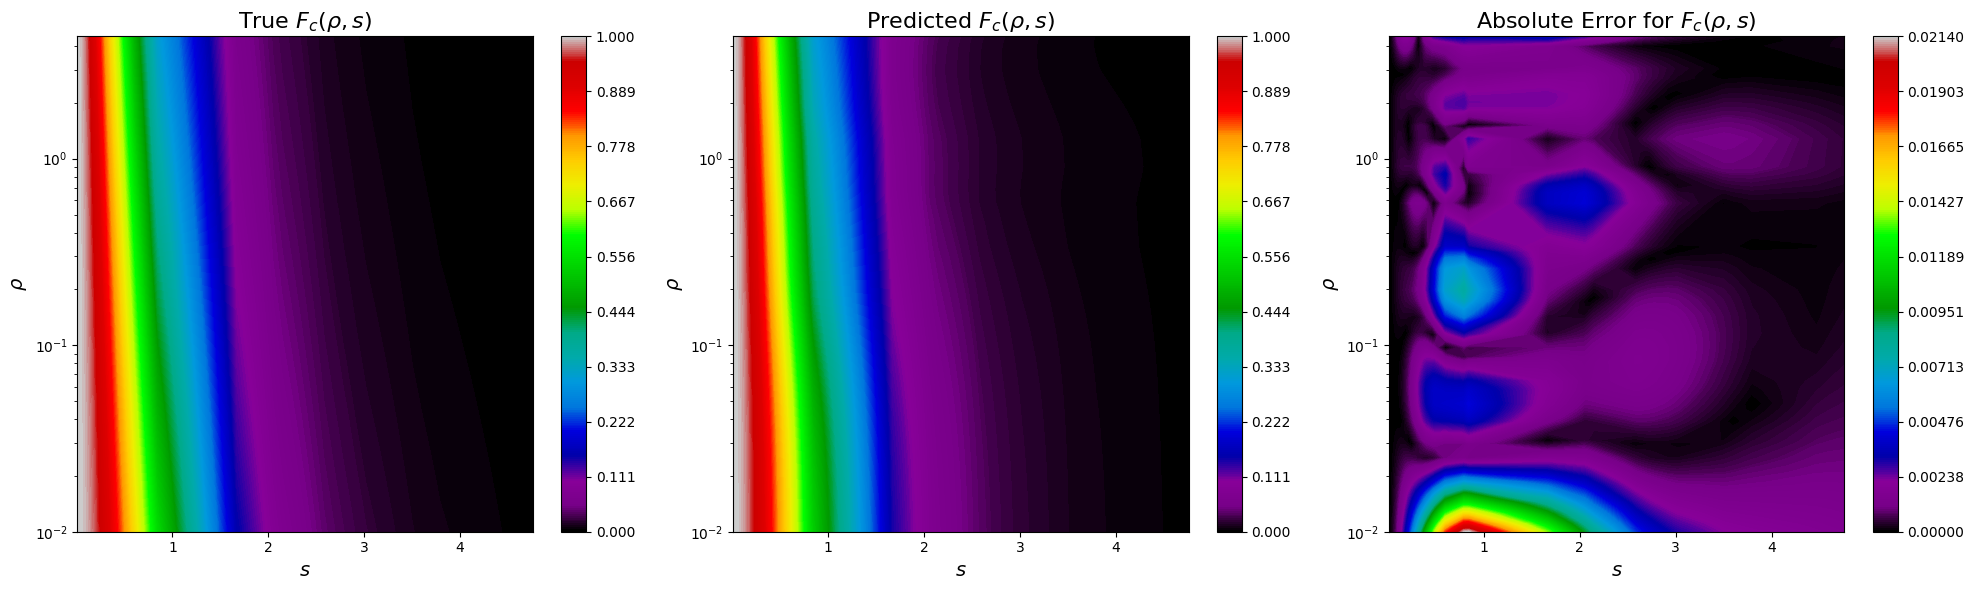

In [110]:
test_s = jnp.array(sorted(ssv[sval_inds]))
test_rho = jnp.array(sorted(srv[sval_inds]))

NUM_S = len(test_s)
NUM_RHO = len(test_rho)

s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
img_sinps = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()**2], axis=1)

true_fx_test = PBE_Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = PBE_Fc(rho_mesh.flatten(), grad_rho_test.flatten())

pred_fx = jax.vmap(snmx)(img_sinps)
pred_fc = jax.vmap(snmc)(img_sinps)

RSLEN = len(val_inds)

true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

ir2_fx, imae_fx, irmse_fx, maxex = calculate_stats(true_fx_test, pred_fx)
ir2_fc, imae_fc, irmse_fc, maxec = calculate_stats(true_fc_test, pred_fc)
# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {ir2_fx:.6f}")
print(f"Mean Absolute Error: {imae_fx:.6f}")
print(f"Root Mean Squared Error: {irmse_fx:.6f}")
print(f"Maximum Absolute Error: {maxex:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {ir2_fc:.6f}")
print(f"Mean Absolute Error: {imae_fc:.6f}")
print(f"Root Mean Squared Error: {irmse_fc:.6f}")
print(f"Maximum Absolute Error: {maxec:.6f}")
plot_contour(true_fx_test, pred_fx, '$F_x(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (1, 1.7), true_vminmax = (1, 1.7), levels=500, ncbarticks = 10, coffset=0)
plot_contour(true_fc_test, pred_fc, '$F_c(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (0, 1.0), true_vminmax = (0, 1.0), levels=500, ncbarticks = 10)


To demonstrate the poor-performing networks.

Fx Statistics:
R-squared: -0.303968
Mean Absolute Error: 0.141200
Root Mean Squared Error: 0.256689
Maximum Absolute Error: 0.666660

Fc Statistics:
R-squared: -0.213664
Mean Absolute Error: 0.296881
Root Mean Squared Error: 0.412149
Maximum Absolute Error: 0.871203
Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 1/1.7
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 1/1.7
Contour: error values - vmin/vmax = 0.002023683638888052/0.666659730563147


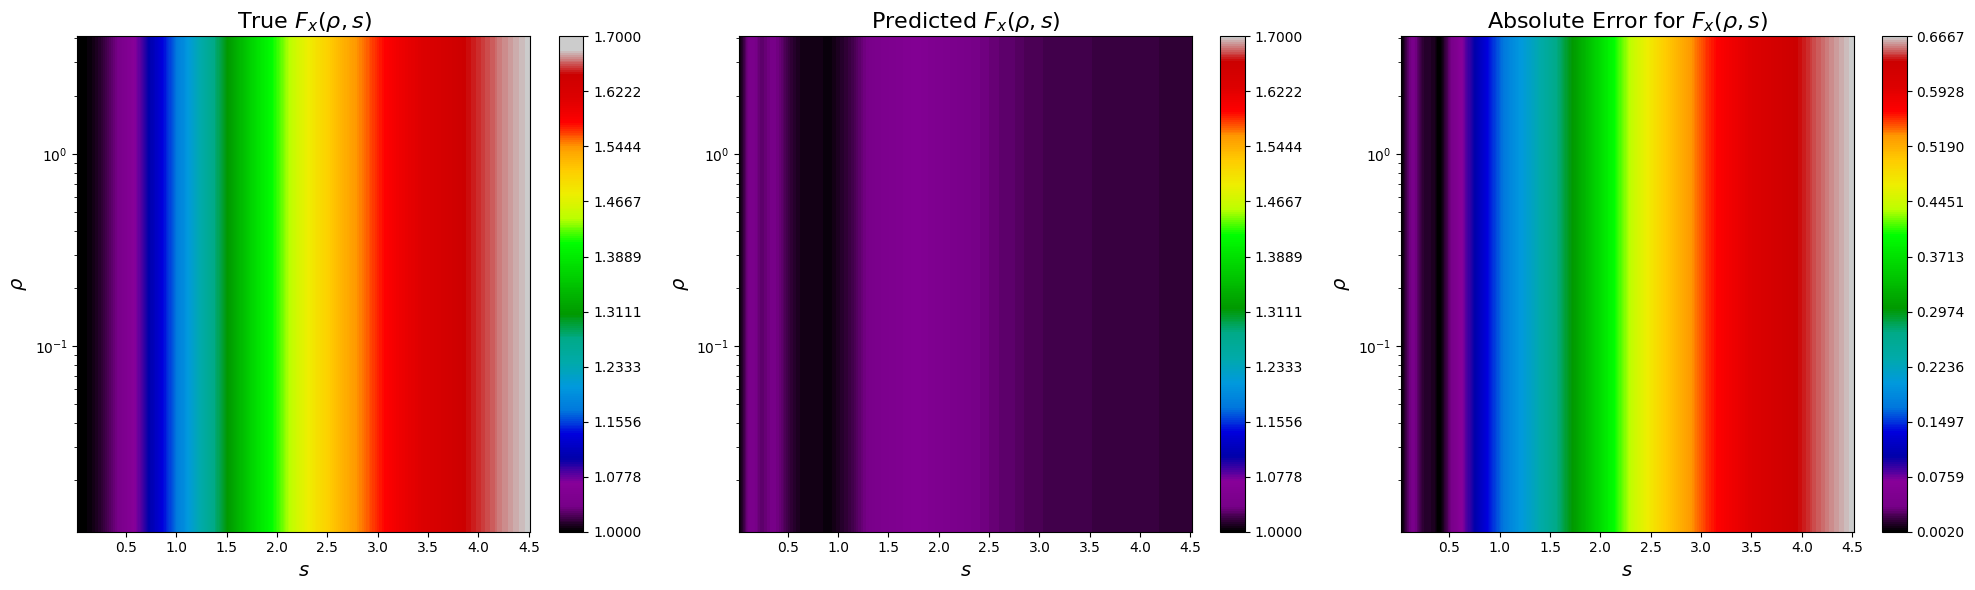

Custom vmin/vmax set -- reading.
Contour: true values - vmin/vmax = 0/1.0
Custom vmin/vmax set -- reading.
Contour: pred values - vmin/vmax = 0/1.0
Contour: error values - vmin/vmax = 0.00016765562145526491/0.8712033917062102


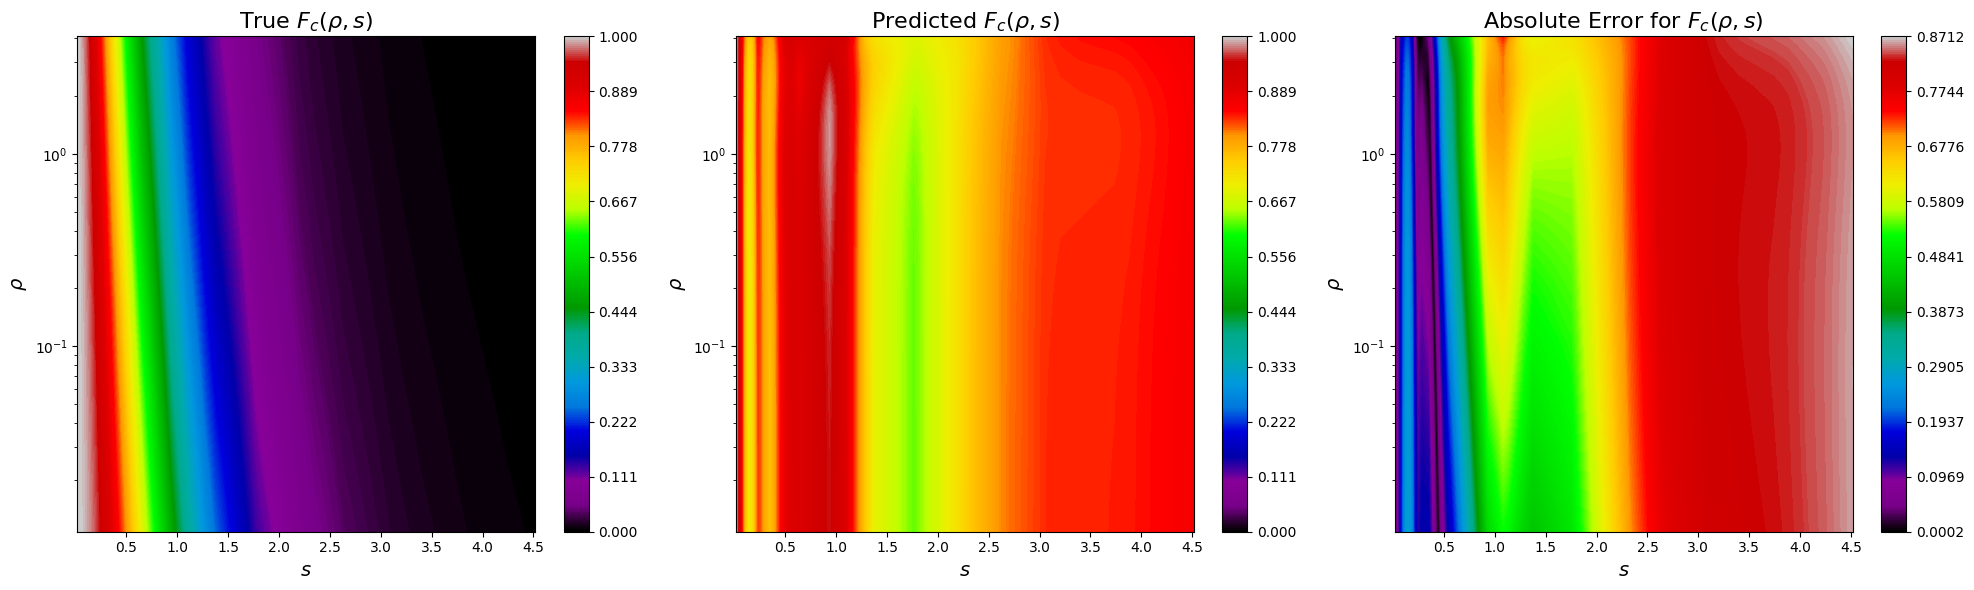

In [111]:
test_s = jnp.array(sorted(ssv2[sval_inds2]))
test_rho = jnp.array(sorted(srv2[sval_inds2]))

NUM_S = len(test_s)
NUM_RHO = len(test_rho)

s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh
img_sinps = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()**2], axis=1)

true_fx_test = PBE_Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = PBE_Fc(rho_mesh.flatten(), grad_rho_test.flatten())

pred_fx = jax.vmap(snmx2)(img_sinps)
pred_fc = jax.vmap(snmc2)(img_sinps)

RSLEN = len(val_inds)

true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

ir2_fx, imae_fx, irmse_fx, maxex = calculate_stats(true_fx_test, pred_fx)
ir2_fc, imae_fc, irmse_fc, maxec = calculate_stats(true_fc_test, pred_fc)
# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {ir2_fx:.6f}")
print(f"Mean Absolute Error: {imae_fx:.6f}")
print(f"Root Mean Squared Error: {irmse_fx:.6f}")
print(f"Maximum Absolute Error: {maxex:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {ir2_fc:.6f}")
print(f"Mean Absolute Error: {imae_fc:.6f}")
print(f"Root Mean Squared Error: {irmse_fc:.6f}")
print(f"Maximum Absolute Error: {maxec:.6f}")
plot_contour(true_fx_test, pred_fx, '$F_x(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (1, 1.7), true_vminmax = (1, 1.7), levels=500, ncbarticks = 10, coffset=0)
plot_contour(true_fc_test, pred_fc, '$F_c(\\rho, s)$', test_rho, test_s, cmap='nipy_spectral', pred_vminmax = (0, 1.0), true_vminmax = (0, 1.0), levels=500, ncbarticks = 10)


# Optimizing PBE Networks

In [22]:
def custom_pbe_Fx(rho, sigma, XNET = None):
    #this will be a call to the Fx neural network we want
    # print('DEBUG custom_pbe_Fx, rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG custom_pbe_Fx: rho: ', rho)
    # print('DEBUG custom_pbe_Fx: sigma: ', sigma)

    Fx = XNET([rho, sigma])
    return Fx

def custom_pbe_Fc(rho, sigma, CNET = None): #Assumes zeta = 0
    #this will be a call to the Fc neural network we want
    Fc = CNET([rho, sigma])
    return Fc

def custom_pbe_e(rho, sigma, XNET = None, CNET = None):
    Fx = custom_pbe_Fx(rho, sigma, XNET = XNET)
    Fc = custom_pbe_Fc(rho, sigma, CNET = CNET)

    exc = lda_x(rho)*Fx + pw92c_unpolarized(rho)*Fc

    return exc

def custom_pbe_epsilon(rho, sigma, XNET = None, CNET = None):

    return rho*custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_e(rhosigma, XNET = None, CNET = None):
    rho, sigma = rhosigma
    # print('DEBUG derivable_custom_pbe_e: rhosigma len/shapes: ', len(rhosigma), rhosigma)
    # print('DEBUG derivable_custom_pbe_e: rho/sigma shapes: ', rho.shape, sigma.shape)
    # print('DEBUG derivable_custom_pbe_e: rho: ', rho)
    # print('DEBUG derivable_custom_pbe_e: sigma: ', sigma)
    return custom_pbe_e(rho, sigma, XNET = XNET, CNET = CNET)

def derivable_custom_pbe_epsilon(rhosigma, XNET = None, CNET = None):
    rho = rhosigma[0]
    sigma = rhosigma[1]
    result = custom_pbe_epsilon(rho, sigma, XNET = XNET, CNET = CNET)
    return result[0]
    
def eval_xc_gga_j(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 XNET = None, CNET = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    rho0, dx, dy, dz = rho[:4]
    rho0 = jnp.array(rho0)
    sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    rhosig = (rho0, sigma)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    derivable_net_e = partial(derivable_custom_pbe_e, XNET = XNET, CNET = CNET)
    derivable_net_epsilon = partial(derivable_custom_pbe_epsilon, XNET = XNET, CNET = CNET)
    exc = np.array(jax.vmap(derivable_net_e)( rhosig ) )
    
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(derivable_net_epsilon)
    vrhosigma = np.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[0], vrhosigma[1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(derivable_net_epsilon)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = np.array(jax.vmap(v2_f)( rhosig ))
    # print('v2 shape', v2.shape)
    v2rho2 = v2[0][0]
    v2rhosigma = v2[0][1]
    v2sigma2 = v2[1][1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc

def eval_xc_gga_j2(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None,
                 xcmodel = None):
    #we only expect there to be a rho0 array, but I unpack it as (rho, deriv) here to be in line with the
    #pyscf example -- the size of the 'rho' array depends on the xc type (LDA, GGA, etc.)
    #so since LDA calculation, check for size first.
    try:
        rho0, dx, dy, dz = rho[:4]
        sigma = jnp.array(dx**2+dy**2+dz**2)
    except:
        rho0, drho = rho[:4]
        sigma = jnp.array(drho**2)
    rho0 = jnp.array(rho0)
    # sigma = jnp.array(dx**2+dy**2+dz**2)
    # print('DEBUG eval_xc_gga_j: rho0/sigma shapes: ', rho0.shape, sigma.shape)
    # rhosig = (rho0, sigma)
    rhosig = jnp.stack([rho0, sigma], axis=1)
    print(rhosig.shape)
    #calculate the "custom" energy with rho -- THIS IS e
    #cast back to np.array since that's what pyscf works with
    #pass as tuple -- (rho, sigma)
    exc = jax.vmap(xcmodel)(rhosig)
    exc = jnp.array(exc)/rho0
    # exc = jnp.array(jax.vmap(xcmodel)( rhosig ) )/rho0
    # print('exc shape = {}'.format(exc.shape))
    #first order derivatives w.r.t. rho and sigma
    vrho_f = eqx.filter_grad(xcmodel)
    vrhosigma = jnp.array(jax.vmap(vrho_f)( rhosig ))
    # print('vrhosigma shape:', vrhosigma.shape)
    vxc = (vrhosigma[:, 0], vrhosigma[:, 1], None, None)

    # v2_f = eqx.filter_hessian(derivable_custom_pbe_epsilon)
    v2_f = jax.hessian(xcmodel)
    # v2_f = jax.hessian(custom_pbe_epsilon, argnums=[0, 1])
    v2 = jnp.array(jax.vmap(v2_f)( rhosig ))
    print('v2 shape', v2.shape)
    v2rho2 = v2[:, 0, 0]
    v2rhosigma = v2[:, 0, 1]
    v2sigma2 = v2[:, 1, 1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    #3rd order
    kxc = None
    
    return exc, vxc, fxc, kxc

In [23]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mol.max_memory = 32000
mf = dft.RKS(mol)
mf.grids.level = 1
mf.xc = 'pbe'
mf.kernel()
ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)
dm = mf.make_rdm1()
rho = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')

In [24]:
mf.e_tot

-76.33342437818284

#### Do a CCSD(T) calculation to get a more accurate energy to target.

In [25]:
start_hf = scf.RHF(mol)
start_hf.kernel()
cc_h2o = cc.CCSD(start_hf)
cc_h2o.kernel()

(-0.21334324588829517,
 array([[ 6.32837811e-05,  3.25880896e-17,  4.20447204e-17,
         -4.60673625e-05,  7.40241332e-05, -1.58276800e-18,
         -5.66694782e-18,  9.19758904e-05,  1.76309683e-19,
          7.63686059e-20, -1.86187389e-04,  1.56250271e-17,
         -7.68731077e-18,  8.62713654e-05,  1.84883782e-19,
         -1.78639440e-19, -5.87393933e-06,  3.21678470e-05,
          2.21836603e-17],
        [-3.91228510e-03, -2.32134065e-17, -2.32369188e-16,
          3.57507648e-05, -4.24256897e-03,  2.65245137e-17,
          6.70951429e-17, -3.68473231e-04, -4.46699491e-18,
          3.05461947e-18, -1.47203123e-03, -8.70369821e-17,
          1.13422897e-17,  2.67542416e-03,  5.88482239e-19,
         -3.56948072e-18, -1.07208920e-04,  9.07975760e-04,
          6.60725806e-18],
        [ 4.35444699e-16,  5.94474731e-03, -1.84260436e-03,
         -1.63492246e-16,  2.71823792e-16,  8.72014775e-17,
         -4.54656237e-03,  2.01321750e-16, -1.82363506e-17,
          6.67624998e-1

In [26]:
cc_h2o.e_tot

-76.24010891900588

In [27]:
TARGET_ENERGY = cc_h2o.e_tot

In [28]:
@eqx.filter_value_and_grad
def opt_loss(model, mols, refs):
    total_loss = 0
    for idx, mol in enumerate(mols):
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        total_loss += abs(mf.e_tot - refs[idx])
    total_loss /= len(mols)
    return total_loss[..., jnp.newaxis][0]

In [29]:
class RXCModel(eqx.Module):
    xnet: eqx.Module
    cnet: eqx.Module

    def __init__(self, xnet, cnet):
        self.xnet = xnet
        self.cnet = cnet
        
    def __call__(self, inputs):
        #this generate epsilon, not exc -- divide end result by rho when needed
        rho = inputs[0]
        sigma = inputs[1]
        # print('RXCModel call - inputs {}'.format(inputs))
        return rho*(lda_x(rho)*jax.vmap(self.xnet)(inputs[..., jnp.newaxis]) + pw92c_unpolarized(rho)*jax.vmap(self.cnet)(inputs[..., jnp.newaxis])).flatten()[0]
        # return rho*(lda_x(rho)*self.xnet(inputs) + pw92c_unpolarized(rho)*self.cnet(inputs)).flatten()[0]

In [30]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mol.max_memory = 32000
molad = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
molad.verbose = 0
molad.max_memory = 32000

test_model = RXCModel(xnet=snmx, cnet=snmc)
sigma_eval_xc = partial(eval_xc_gga_j2, xcmodel=test_model)
mf2 = dft_ad.RKS(molad)
mf2.grids.level = 1
mf2.define_xc_(sigma_eval_xc, 'GGA')
mf2.kernel()

Initialize <pyscfad.gto.mole.Mole object at 0x7f4f6c555cc0> in RKS-KohnShamDFT object of <class 'pyscfad.dft.rks.RKS'>
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9

Array(-76.03205357, dtype=float64)

In [31]:
from typing import Callable

class Optimizer(eqx.Module):
    model: eqx.Module
    optim: optax.GradientTransformation
    steps: int
    print_every: int
    opt_state: tuple
    mols: list
    refs: jnp.array
    loss: Callable

    def __init__(self, model, optim, mols, refs, loss, steps=1000, print_every=100):
        '''
        The Pretrainer object aids in the initial pre-training of enhancement factor networks to have a more physical starting point for further network optimization. This class is meant to pre-train a randomly initialized network to fit the values of a specific XC functional's enhancement factor (either X or C, in principle it could also be a combined XC enhancement facator)

        :param model: The enhancement factor network to be pre-trained
        :type model: :xcquinox.net: class
        :param optim: The optimizer than will control the weight updates given a loss and gradient
        :type optim: optax.GradientTransformation
        :param inputs: The inputs the network itself is expecting in its forward pass function
        :type inputs: jnp.array
        :param ref: The reference values the network is expected to reproduce
        :type ref: jnp.array
        :param loss: A function from :xcquinox.loss: that is decorated with @eqx.filter_value_and_grad
        :type loss: Callable
        :param steps: Number of epochs to train over, defaults to 1000
        :type steps: int, optional
        :param print_every: How often to print loss statistic, defaults to 100
        :type print_every: int, optional
        '''
        super().__init__()
        self.model = model
        self.optim = optim
        self.mols = mols
        self.refs = refs
        self.steps = steps
        self.print_every = print_every
        self.opt_state = self.optim.init(eqx.filter(self.model, eqx.is_array))
        self.loss = loss

    def __call__(self):
        '''
        The training loop itself. Here, a loop over the specifed epochs takes place to train the network to fit reference values.

        :return: The trained model and an array of the losses during training.
        :rtype: (:xcquinox.net: class, array)
        '''
        losses = []
        for epoch in range(self.steps):
            if epoch == 0:
                this_model = self.model
                this_opt_state = self.opt_state
            loss, this_model, this_opt_state = self.make_step(this_model, self.mols, self.refs, this_opt_state)
            lossi = loss.item()
            losses.append(lossi)
            if epoch % self.print_every == 0:
                print(f'Epoch {epoch}: Loss = {lossi}')

        return this_model, losses

    # @eqx.filter_jit
    def make_step(self, model, inputs, ref, opt_state):
        '''
        The function that does each epoch's network update. It generates a loss and gradient using the specific :xcquinox.loss: function (that must be decorated with @eqx.filter_value_and_grad and only explicitly returns the loss value inside the function proper) given the specified inputs and reference values and initial optimization state.

        :param model: The enhancement factor network to be pre-trained
        :type model: :xcquinox.net: class
        :param inputs: The inputs the network itself is expecting in its forward pass function
        :type inputs: jnp.array
        :param ref: The reference values the network is expected to reproduce
        :type ref: jnp.array
        :param opt_state: The INITIAL optimization state to work against, typically generated via :self.optim.init(eqx.filter(self.model, eqx.is_array)):
        :type opt_state: The type of the above
        :return: The loss value for this step, the updated model after that loss is calculated, and the new optimization state for this step to use next time
        :rtype: tuple
        '''
        loss, grad = self.loss(model, self.mols, self.refs)
        updates, opt_state = self.optim.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state


In [32]:
mol_ad = gto_ad.Mole(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol_ad.max_memory = 32000
mol_ad.build()
mol_ad.verbose = 0
opt_opt = optax.chain(
    optax.adam(learning_rate=1e-3)
)
opt_snmxc = Optimizer(model=test_model, optim=opt_opt, mols = [mol_ad], refs = [TARGET_ENERGY], loss=opt_loss, print_every=1, steps=50)

In [33]:
osnmxc, osnmxcl = opt_snmxc()

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9082, 2)
v2 shape (9082, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 9082, 24), weight.shape=(9082,), coords.shape=(9082, 3)
(9

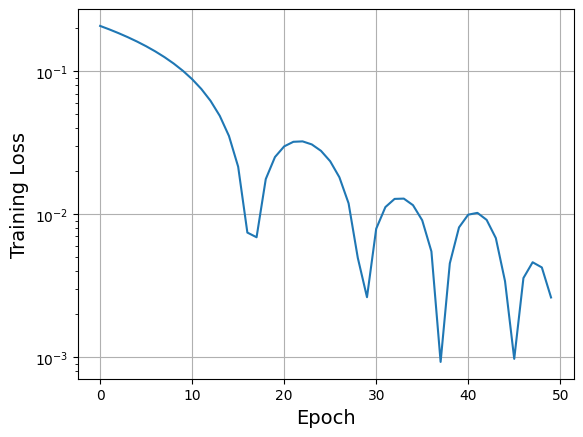

In [102]:
plt.plot(osnmxcl)
plt.yscale('log')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training Loss', fontsize=14)
plt.grid()

In [35]:
sigma_eval_xc_opt = partial(eval_xc_gga_j2, xcmodel=osnmxc)
mf3 = dft.RKS(mol)
mf3.grids.level = 1
mf3.define_xc_(sigma_eval_xc_opt, 'GGA')
mf3.kernel()

(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)
(9088, 2)
v2 shape (9088, 2, 2)


-76.24025791092114

### Some light validation testing

In [36]:
pt = gto_ad.Mole(atom='''O 1.310944 -0.092374  0.053983;
                   H 1.955110  0.571413 -0.263648;
                   H -0.101366  0.045774 -0.012031;
                   O -1.149037  0.029559 -0.084434;
                   H -1.608104  0.722348  0.414070;
                   H -1.540923 -0.836961  0.105186''',
            basis='DZVP')
pt.verbose = 5
pt.charge = 1
pt.spin = 1
pt.build()
hb = gto_ad.Mole(atom='''O 1.317021 -0.128356 0.006258;
                    H 1.527437 0.387478 -0.795622;
                    H 1.505382 0.474880 0.750724;
                    O -1.017021 0.128356 0.006258;
                    H -1.227437 -0.387478 -0.795622; 
                    H -1.205382 -0.474880 0.750724''',
            basis='DZVP', unit='angstrom')
hb.build()
hb.verbose = 5
hb.charge = 1
hb.spin = 1

pt.max_memory = 32000
hb.max_memory = 32000

System: uname_result(system='Linux', node='aegis', release='5.15.0-131-generic', version='#141~20.04.1-Ubuntu SMP Thu Jan 16 18:38:51 UTC 2025', machine='x86_64')  Threads 20
Python 3.10.14 (main, Mar 21 2024, 16:24:04) [GCC 11.2.0]
numpy 1.26.4  scipy 1.11.4
Date: Mon Mar  3 07:59:31 2025
PySCF version 2.3.0
PySCF path  /home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file /home/awills/.pyscf_conf.py
[INPUT] verbose = 5
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 6
[INPUT] num. electrons = 19
[INPUT] charge = 1
[INPUT] spin (= nelec alpha-beta = 2S) = 1
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 O      1.310944000000  -0.092374000000   0.053983000000 AA    2.477325124642  -0.174561561031   0.102013085382 Bohr   0.0
[INPUT]  2 H      1.955110000000   0.571413000000  -0.2636480000

In [37]:
#CCSD(T) reference
hb_hf = scf.RHF(hb)
pt_hf = scf.RHF(pt)
hb_hf.kernel()
pt_hf.kernel()

hb_cc = cc.CCSD(hb_hf)
pt_cc = cc.CCSD(pt_hf)
hb_cc.kernel()
pt_cc.kernel()

hb_ccsdt = hb_cc.ccsd_t()
pt_ccsdt = pt_cc.ccsd_t()



******** <class 'pyscf.scf.rohf.ROHF'> ********
method = ROHF-RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/xcquinox/notebooks/tmp6_in7t53
max_memory 32000 MB (current use 5095 MB)
num. doubly occ = 9  num. singly occ = 1
Set gradient conv threshold to 3.16228e-05
E1 = -285.79461435777534  Ecoul = 94.6442993538524
init E= -151.657312532694
cond(S) = 62.79751901147895
    CPU time for initialize scf      6.10 sec, wall time      0.39 sec
  HOMO = -0.399995350649482  LUMO = 0.087434633465911
                  Roothaan           | alpha              | beta
  Highest 2-occ = -0.515562293854997 | -0.515562293854996 | -0.515562293854996
  Lowest 0-occ =   0.087434633465911 | 0.0874346334659122 | 0.0874346334659122
  1-occ =       

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


E1 = -281.70146397167025  Ecoul = 90.56532803202856
cycle= 3 E= -151.643133468413  delta_E= -0.00114  |g|= 0.0187  |ddm|= 0.0434
    CPU time for cycle= 3      1.62 sec, wall time      0.10 sec
  HOMO = -0.57777269685697  LUMO = -0.0601762851539325
                  Roothaan           | alpha              | beta
  Highest 2-occ =  -0.79538622052759 |   -0.9198924976516 | -0.672004595891361
  Lowest 0-occ =  -0.0601762851539325 | -0.0647479411852846 | -0.0562019831293644
  1-occ =          -0.57777269685697 | -0.849784482090372 | -0.306862938716773
  Roothaan mo_energy =
[-2.09106603e+01 -2.09106481e+01 -1.68054474e+00 -1.65696026e+00
 -1.04431822e+00 -1.02982426e+00 -9.15605890e-01 -9.09771580e-01
 -7.95386221e-01 -5.77772697e-01 -6.01762852e-02 -5.80919615e-03
  3.81800690e-02  3.95665256e-02  4.64037645e-01  4.97297920e-01
  5.46289019e-01  5.81864807e-01  6.04770972e-01  6.41453588e-01
  8.07462969e-01  8.12560240e-01  8.17823211e-01  9.18316098e-01
  1.26775879e+00  1.54794053e+00 

In [38]:
CC_HB_E = hb_cc.e_tot + hb_ccsdt
CC_PT_E = pt_cc.e_tot + pt_ccsdt
print('CCSD(T) HB - PT = {} H'.format(CC_HB_E - CC_PT_E))

CCSD(T) HB - PT = 0.014314063139067912 H


In [39]:
#PBE - PySCF Value
hb_pbe = dft.RKS(hb)
hb_pbe.xc = 'pbe'
hb_pbe = hb_pbe.newton()
hb_pbe.grids.level = 3
hb_pbe.kernel()





******** <class 'pyscf.dft.roks.ROKS'> ********
method = ROKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/xcquinox/notebooks/tmpzpx8blgl
max_memory 32000 MB (current use 5104 MB)
num. doubly occ = 9  num. singly occ = 1
XC library pyscf.dft.libxc version 6.1.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = pbe
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
radial grids: 
    Treutler-Ahlr

Array(-152.33444684, dtype=float64)

In [40]:
pt_pbe = dft.RKS(pt)
pt_pbe.xc = 'pbe'
pt_pbe = pt_pbe.newton()
pt_pbe.grids.level = 3
pt_pbe.kernel(pt_hf.mo_coeff, pt_hf.mo_occ)





******** <class 'pyscf.dft.roks.ROKS'> ********
method = ROKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/xcquinox/notebooks/tmp489a84sa
max_memory 32000 MB (current use 5105 MB)
num. doubly occ = 9  num. singly occ = 1
XC library pyscf.dft.libxc version 6.1.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = pbe
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 77, 3865 (1996)
    J. P. Perdew, K. Burke, and M. Ernzerhof.,  Phys. Rev. Lett. 78, 1396 (1997)
radial grids: 
    Treutler-Ahlr

Array(-152.31873828, dtype=float64)

In [41]:
PBE_HB_E = hb_pbe.e_tot
PBE_PT_E = pt_pbe.e_tot
print('PBE (PySCF) HB - PT = {} H'.format(PBE_HB_E - PBE_PT_E))

PBE (PySCF) HB - PT = -0.015708554715729406 H


### Network calculations.

In [42]:
pt = gto.M(atom='''O 1.310944 -0.092374  0.053983;
                   H 1.955110  0.571413 -0.263648;
                   H -0.101366  0.045774 -0.012031;
                   O -1.149037  0.029559 -0.084434;
                   H -1.608104  0.722348  0.414070;
                   H -1.540923 -0.836961  0.105186''',
            basis='DZVP')
pt.verbose = 5
pt.charge = 1
pt.spin = 1
pt.build()
hb = gto.M(atom='''O 1.317021 -0.128356 0.006258;
                    H 1.527437 0.387478 -0.795622;
                    H 1.505382 0.474880 0.750724;
                    O -1.017021 0.128356 0.006258;
                    H -1.227437 -0.387478 -0.795622; 
                    H -1.205382 -0.474880 0.750724''',
            basis='DZVP', unit='angstrom')
hb.build()
hb.verbose = 5
hb.charge = 1
hb.spin = 1

ptad = gto_ad.Mole(atom='''O 1.310944 -0.092374  0.053983;
                   H 1.955110  0.571413 -0.263648;
                   H -0.101366  0.045774 -0.012031;
                   O -1.149037  0.029559 -0.084434;
                   H -1.608104  0.722348  0.414070;
                   H -1.540923 -0.836961  0.105186''',
            basis='DZVP')
ptad.verbose = 5
ptad.charge = 1
ptad.spin = 1
ptad.build()
hbad = gto_ad.Mole(atom='''O 1.317021 -0.128356 0.006258;
                    H 1.527437 0.387478 -0.795622;
                    H 1.505382 0.474880 0.750724;
                    O -1.017021 0.128356 0.006258;
                    H -1.227437 -0.387478 -0.795622; 
                    H -1.205382 -0.474880 0.750724''',
            basis='DZVP', unit='angstrom')
hbad.build()
hbad.verbose = 5
hbad.charge = 1
hbad.spin = 1

hb.max_memory = 32000
pt.max_memory = 32000
hbad.max_memory = 32000
ptad.max_memory = 32000


System: uname_result(system='Linux', node='aegis', release='5.15.0-131-generic', version='#141~20.04.1-Ubuntu SMP Thu Jan 16 18:38:51 UTC 2025', machine='x86_64')  Threads 20
Python 3.10.14 (main, Mar 21 2024, 16:24:04) [GCC 11.2.0]
numpy 1.26.4  scipy 1.11.4
Date: Mon Mar  3 08:01:38 2025
PySCF version 2.3.0
PySCF path  /home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file /home/awills/.pyscf_conf.py
[INPUT] verbose = 5
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 6
[INPUT] num. electrons = 19
[INPUT] charge = 1
[INPUT] spin (= nelec alpha-beta = 2S) = 1
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 O      1.310944000000  -0.092374000000   0.053983000000 AA    2.477325124642  -0.174561561031   0.102013085382 Bohr   0.0
[INPUT]  2 H      1.955110000000   0.571413000000  -0.2636480000

In [43]:
#random network, un pre-trained
ran_model = RXCModel(xnet = spbe_fx, cnet = spbe_fc)
#pre-trained network
pt_model = RXCModel(xnet = snmx, cnet = snmc)
#optimized network
opt_model = osnmxc

In [44]:
hb_net = dft_ad.RKS(hbad)
pt_net = dft_ad.RKS(ptad)
hb_net.grids.level = 3
pt_net.grids.level = 3

In [45]:
random_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=ran_model)
hb_net.define_xc_(random_net_eval_xc, 'GGA')
pt_net.define_xc_(random_net_eval_xc, 'GGA')

hb_net.kernel()
pt_net.kernel()


WARN: Invalid number of electrons 19 for RHF method.

Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
cond(S) = 62.79751901147895
atom O rad-grids = 75, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50  50
  50  50  50  50  86  86  86  86  86  86  86  86  86 266 266 266 266 266
 266 266 302 302 302 302 302 302 302 302 302 302 302 302 302 302 302 302
 302 302 302 266 266 266 266 266 266 266 266 266 266 266 266 266 266 266
 266 266 266]
atom H rad-grids = 50, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86
 266 266 266 266 302 302 302 302 302 302 302 302 302 302 302 302 302 266
 266 266 266 266 266 266 266 266 266 266 266 266 266 266]
tot_boxes 1430, boxes in each direction [11  8  9]
Padding 4 grids
tot grids = 68624
    CPU time for setting up grids      4.12 sec, wall time      0.45 sec
GGA ni.block_loop; input ao.shape=(4, 67200, 36), weight.shape=(67200,), coords.shape=(67200, 3)
(67200, 2)
v2

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 67200, 36), weight.shape=(67200,), coords.shape=(67200, 3)
(67200, 2)
v2 shape (67200, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 1424, 36), weight.shape=(1424,), coords.shape=(1424, 3)
(1424, 2)
v2 shape (1424, 2, 2)
nelec by numeric integration = 17.999998613939923
    CPU time for vxc      7.44 sec, wall time      2.22 sec
E1 = -275.6048321998123  Ecoul = 102.2695878848604  Exc = -16.892074560822063
cycle= 2 E= -150.734316404545  delta_E= -0.0017  |g|= 0.277  |ddm|= 0.543
    CPU time for cycle = 2      7.56 sec, wall time      2.29 sec
  HOMO = -0.963430235977324  LUMO = -0.924604289745719
  mo_energy =
[-1.93400301e+01 -1.93400300e+01 -1.60402580e+00 -1.58835077e+00
 -1.13436194e+00 -1.12327702e+00 -1.01482194e+00 -9.88352402e-01
 -9.63430236e-01 -9.24604290e-01 -5.13711721e-01 -4.70998333e-01
 -4.21250279e-01 -4.19764365e-01 -9.34861554e-02 -9.10369537e-02
 -3.96008934e-02 -3.32498704e-03  2.89554647e-02  9.26320397e-02
  2.06859024e-01  2.1

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


    CPU time for setting up grids      4.66 sec, wall time      0.33 sec
GGA ni.block_loop; input ao.shape=(4, 67200, 36), weight.shape=(67200,), coords.shape=(67200, 3)
(67200, 2)
v2 shape (67200, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 1424, 36), weight.shape=(1424,), coords.shape=(1424, 3)
(1424, 2)
v2 shape (1424, 2, 2)
nelec by numeric integration = 19.98716989676123
    CPU time for vxc      7.83 sec, wall time      2.08 sec
E1 = -285.7414248086429  Ecoul = 111.83471427591532  Exc = -17.411544267656144
init E= -151.863149687868
    CPU time for initialize scf     16.81 sec, wall time      2.67 sec
  HOMO = -0.376290228051364  LUMO = -0.369324782931954
  mo_energy =
[-18.81100746 -18.76137209  -1.0693147   -0.96040531  -0.60228739
  -0.59632217  -0.48496948  -0.43792062  -0.37629023  -0.36932478
  -0.02823451   0.01954038   0.04922769   0.16479468   0.36287758
   0.3863779    0.44508863   0.51258181   0.53652215   0.65891337
   0.67451783   0.71117229   0.72224783   0.76125139

Array(-149.3277528, dtype=float64)

In [46]:
hb_net.converged, pt_net.converged

(True, False)

In [47]:
RAN_HB_E = hb_net.e_tot
RAN_PT_E = pt_net.e_tot
print('PBE (PySCF) HB - PT = {} H'.format(RAN_HB_E - RAN_PT_E))

PBE (PySCF) HB - PT = -1.4270685643049603 H


In [48]:
pretrain_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=pt_model)
hb_net = dft_ad.RKS(hbad)
pt_net = dft_ad.RKS(ptad)
hb_net.define_xc_(pretrain_net_eval_xc, 'GGA')
pt_net.define_xc_(pretrain_net_eval_xc, 'GGA')
hb_net.grids.level = 1
pt_net.grids.level = 1
hb_net.kernel()
pt_net.kernel()
hb_net.converged, pt_net.converged


WARN: Invalid number of electrons 19 for RHF method.

Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
cond(S) = 62.79751901147895
atom O rad-grids = 40, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86 170
 170 170 194 194 194 194 194 194 194 194 194 194 194 170 170 170 170 170
 170 170 170 170]
atom H rad-grids = 30, ang-grids = [ 50  50  50  50  50  50  50  50  86  86  86  86  86 110 110 110 110 110
 110 110 110  86  86  86  86  86  86  86  86  86]
tot_boxes 1430, boxes in each direction [11  8  9]
Padding 0 grids
tot grids = 20344
    CPU time for setting up grids      2.39 sec, wall time      0.27 sec
GGA ni.block_loop; input ao.shape=(4, 20344, 36), weight.shape=(20344,), coords.shape=(20344, 3)
(20344, 2)
v2 shape (20344, 2, 2)
nelec by numeric integration = 19.98765274487382
    CPU time for vxc      8.53 sec, wall time      5.98 sec
E1 = -285.7946143577753  Ecoul = 111.87130658267893  Exc = -17.639055203854323
init E= -152.0

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (20344, 2, 2)
nelec by numeric integration = 17.99996735843089
    CPU time for vxc      2.90 sec, wall time      0.80 sec
E1 = -275.82413960313556  Ecoul = 102.52220615952004  Exc = -17.091353466670284
cycle= 2 E= -150.900284439057  delta_E= 0.00653  |g|= 0.377  |ddm|= 0.635
    CPU time for cycle = 2      2.96 sec, wall time      0.82 sec
  HOMO = -0.972208059169837  LUMO = -0.933419121351155
  mo_energy =
[-1.93668350e+01 -1.93668350e+01 -1.61150047e+00 -1.59514460e+00
 -1.14326686e+00 -1.13130597e+00 -1.02634815e+00 -9.98167153e-01
 -9.72208059e-01 -9.33419121e-01 -5.39512168e-01 -4.95021721e-01
 -4.40701244e-01 -4.39059764e-01 -1.29486479e-01 -1.29045223e-01
 -7.07509264e-02 -3.47327476e-02 -1.23476185e-03  5.84076196e-02
  2.06396221e-01  2.12753752e-01  2.14917131e-01  2.96518472e-01
  6.06010047e-01  8.56461305e-01  9.71076712e-01  9.85331903e-01
  9.88765886e-01  1.01916306e+00  1.05625922e+00  1.16150121e+00
  1.51471165e+00  1.52887670e+00  1.71731034e+00  1.8017857

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


    CPU time for setting up grids      3.60 sec, wall time      0.23 sec
GGA ni.block_loop; input ao.shape=(4, 20344, 36), weight.shape=(20344,), coords.shape=(20344, 3)
(20344, 2)
v2 shape (20344, 2, 2)
nelec by numeric integration = 19.987190636277347
    CPU time for vxc      2.86 sec, wall time      0.80 sec
E1 = -285.7414248086429  Ecoul = 111.83471427591532  Exc = -17.655641779686388
init E= -152.107247199898
    CPU time for initialize scf     10.80 sec, wall time      1.33 sec
  HOMO = -0.372769871977721  LUMO = -0.367716567061604
  mo_energy =
[-1.88110452e+01 -1.87614108e+01 -1.05986955e+00 -9.52175879e-01
 -5.93518034e-01 -5.88579186e-01 -4.79320206e-01 -4.34389824e-01
 -3.72769872e-01 -3.67716567e-01 -5.63351498e-02 -5.88276108e-03
  2.69271427e-02  1.48867420e-01  3.31571368e-01  3.55428666e-01
  4.18343051e-01  4.87785601e-01  5.07892893e-01  6.36126162e-01
  6.66548887e-01  7.15986566e-01  7.28305034e-01  7.65002379e-01
  1.19954959e+00  1.47908400e+00  1.52007942e+00  1

(True, False)

In [49]:
PRE_HB_E = hb_net.e_tot
PRE_PT_E = pt_net.e_tot
print('PBE (PySCF) HB - PT = {} H'.format(PRE_HB_E - PRE_PT_E))

PBE (PySCF) HB - PT = -0.19174054322095913 H


In [50]:
opt_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=osnmxc)
hb_net = dft_ad.RKS(hbad)
pt_net = dft_ad.RKS(ptad)
hb_net.define_xc_(pretrain_net_eval_xc, 'GGA')
pt_net.define_xc_(pretrain_net_eval_xc, 'GGA')
hb_net.grids.level = 1
pt_net.grids.level = 1
hb_net.kernel()
pt_net.kernel()
hb_net.converged, pt_net.converged


WARN: Invalid number of electrons 19 for RHF method.

Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
cond(S) = 62.79751901147895
atom O rad-grids = 40, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86 170
 170 170 194 194 194 194 194 194 194 194 194 194 194 170 170 170 170 170
 170 170 170 170]
atom H rad-grids = 30, ang-grids = [ 50  50  50  50  50  50  50  50  86  86  86  86  86 110 110 110 110 110
 110 110 110  86  86  86  86  86  86  86  86  86]
tot_boxes 1430, boxes in each direction [11  8  9]
Padding 0 grids
tot grids = 20344
    CPU time for setting up grids      2.13 sec, wall time      0.13 sec
GGA ni.block_loop; input ao.shape=(4, 20344, 36), weight.shape=(20344,), coords.shape=(20344, 3)
(20344, 2)
v2 shape (20344, 2, 2)
nelec by numeric integration = 19.98765274487382
    CPU time for vxc      2.99 sec, wall time      0.78 sec
E1 = -285.7946143577753  Ecoul = 111.87130658267893  Exc = -17.639055203854323
init E= -152.0

(True, False)

In [51]:
OPT_HB_E = hb_net.e_tot
OPT_PT_E = pt_net.e_tot
print('PBE (PySCF) HB - PT = {} H'.format(OPT_HB_E - OPT_PT_E))

PBE (PySCF) HB - PT = -0.19174054322095913 H


# Testing - WATER27 Dataset

In [52]:
w27systems = {
    'OHmH2O4c4' : { 'atoms' : ['H', 'H', 'H', 'H', 'O', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H'], 'coords' : [[-0.0267918, 1.5818251, 0.2834249], [1.5818251, 0.0267918, 0.2834249], [0.0267918, -1.5818251, 0.2834249], [-1.5818251, -0.0267918, 0.2834249], [0.0, 0.0, 0.9578999], [0.0, 0.0, 1.9177035], [0.0314199, 2.4185664, -0.2529905], [2.4185664, -0.0314199, -0.2529905], [-0.0314199, -2.4185664, -0.2529905], [-2.4185664, 0.0314199, -0.2529905], [0.843048, 2.2785225, -0.7493353], [2.2785225, -0.843048, -0.7493353], [-0.843048, -2.2785225, -0.7493353], [-2.2785225, 0.843048, -0.7493353]], 'charge' : -1, 'spin' : 0 },
    'H2O8d2d' : { 'atoms' : ['O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-1.4645552, -1.4645552, 1.3497067], [-1.4645552, 1.4645552, -1.3497067], [1.4645552, -1.4645552, -1.3497067], [1.4645552, 1.4645552, 1.3497067], [-1.5346654, -1.5346654, 0.3622554], [-1.5346654, 1.5346654, -0.3622554], [1.5346654, -1.5346654, -0.3622554], [1.5346654, 1.5346654, 0.3622554], [-2.0896636, -2.0896636, 1.7251112], [-2.0896636, 2.0896636, -1.7251112], [2.0896636, -2.0896636, -1.7251112], [2.0896636, 2.0896636, 1.7251112], [-1.4052886, -1.4052886, -1.3390082], [-1.4052886, 1.4052886, 1.3390082], [1.4052886, -1.4052886, 1.3390082], [1.4052886, 1.4052886, -1.3390082], [-1.5526158, -0.4620645, -1.5268989], [-1.5526158, 0.4620645, 1.5268989], [1.5526158, -0.4620645, 1.5268989], [-0.4620645, -1.5526158, -1.5268989], [0.4620645, 1.5526158, -1.5268989], [0.4620645, -1.5526158, 1.5268989], [-0.4620645, 1.5526158, 1.5268989], [1.5526158, 0.4620645, -1.5268989]], 'charge' : 0, 'spin' : 0 },
    'H2O20es' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.4449507, -2.3192362, 1.3852172], [0.9523409, -1.4842602, 1.5288696], [2.3694569, -2.1139495, 1.6116655], [1.4198689, -2.4626094, -1.4007113], [1.4412349, -2.4945724, -0.4194091], [0.7771617, -3.1468464, -1.6575718], [0.0068371, 0.0172196, 1.4027157], [0.3893324, 0.9065634, 1.5625403], [-0.9609503, 0.0503272, 1.5609821], [-2.7367283, -0.0717073, 1.3588421], [-2.7881947, -0.0946107, 0.3779034], [-2.9785985, -0.9717563, 1.6413949], [4.0454641, 1.4627919, -1.4612681], [4.7881071, 1.7639854, -1.9912934], [4.0333238, 0.4731882, -1.5313495], [-1.0008037, 4.2249605, 1.4982864], [-1.152189, 5.0082615, 2.0335617], [-1.8328395, 3.6856129, 1.5416327], [-3.2272404, 2.7492225, -1.5453255], [-3.8412573, 3.2117349, -2.121788], [-2.3703373, 3.2485931, -1.5888707], [0.061546, -0.0608668, -1.3504788], [0.5404095, -0.8892136, -1.5688996], [0.0525024, -0.0517312, -0.3661063], [1.3505765, 2.3624375, -1.4255501], [2.2943427, 2.2180386, -1.6165285], [0.9255618, 1.4877943, -1.5595341], [4.0797114, -1.2705898, 1.5101742], [4.8184302, -1.5307198, 2.0667554], [4.0088205, -0.2833084, 1.5792807], [-0.9118416, 4.114684, -1.3968277], [-0.8699572, 4.3289684, -0.4493559], [-0.0897473, 3.6305502, -1.5859742], [-2.6850195, -0.0424816, -1.4274401], [-2.9831436, 0.8560006, -1.6562177], [-1.7132338, -0.0438086, -1.5635337], [-3.1295491, -2.8665515, -1.3299376], [-3.1140901, -1.9191429, -1.5480976], [-3.3032413, -2.9025862, -0.3736924], [1.224434, 2.4780105, 1.3595377], [0.5812433, 3.1657978, 1.6076146], [1.272843, 2.5161003, 0.3793006], [-0.812813, -4.2331318, -1.5239325], [-0.9466607, -5.0213678, -2.0566534], [-1.663369, -3.7232425, -1.5543692], [-3.2498861, 2.7544587, 1.3479831], [-3.1924627, 1.8120206, 1.5790401], [-3.4347595, 2.7666931, 0.3928574], [4.0373837, -1.2313563, -1.3812425], [3.2335259, -1.7195098, -1.6240819], [4.1604036, -1.4012254, -0.4312943], [-3.094015, -2.885118, 1.5661544], [-2.2180185, -3.3510614, 1.5943976], [-3.6898242, -3.3867826, 2.1285951], [-0.7332536, -4.1659349, 1.3697764], [0.0709231, -3.6538397, 1.5619151], [-0.6879895, -4.3597798, 0.4176959], [3.9098072, 1.4164687, 1.4257218], [3.0660482, 1.8495739, 1.636771], [4.0554225, 1.5928403, 0.4801529]], 'charge' : 0, 'spin' : 0 },
    'H2O20fs' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-0.4674337, -1.4156432, 2.3424832], [-0.5103881, -0.5327785, 2.7383509], [-1.154371, -1.4135419, 1.6390602], [-1.1804953, -4.411489, -2.0217879], [-1.6005951, -5.0804995, -2.5684061], [-1.6296589, -4.4443491, -1.1306922], [-0.3890822, -4.3416186, 2.3649217], [-0.4122318, -3.4254374, 2.6780297], [0.495447, -4.4516812, 1.9766411], [-2.370827, -1.4010748, 0.3317388], [-2.7687053, -0.5190604, 0.3764393], [-1.9008133, -1.4312776, -0.5314561], [-1.0412215, -1.5773429, -2.0898648], [-0.0740952, -1.5478577, -1.9182976], [-1.2210828, -2.5028893, -2.3334269], [1.6403031, -4.3519848, -1.6030968], [0.6907637, -4.4791178, -1.78646], [1.8234428, -3.4332488, -1.8548591], [-2.332464, -4.3191108, 0.3710663], [-1.6749165, -4.4161499, 1.0945673], [-2.663344, -3.4130595, 0.4587135], [1.6787401, -1.4676579, -1.5895498], [1.8042491, -1.4683808, -0.6135222], [1.9691284, -0.5921861, -1.8871045], [2.0177788, -1.5700244, 1.1457336], [1.1343262, -1.5367783, 1.5764315], [2.3187166, -2.4899023, 1.2541941], [2.1824622, -4.3930741, 1.0311736], [2.8554348, -5.0463468, 1.2384494], [2.0031126, -4.4627308, 0.0573709], [-0.4152401, 4.3842505, 2.2876138], [-0.5679834, 5.06537, 2.9479304], [-1.1127701, 4.487654, 1.6038264], [-1.1046614, 1.2760042, -2.0786808], [-1.2737935, 0.3860585, -2.4278927], [-1.5421398, 1.2973941, -1.1984656], [-0.3343417, 1.482161, 2.3157837], [0.5348035, 1.4101401, 1.8606636], [-0.3797162, 2.3986009, 2.6294913], [-2.2749913, 4.3768946, 0.233996], [-1.7988517, 4.3462894, -0.6427551], [-2.9812564, 5.0213482, 0.1371479], [-0.9933823, 4.1431644, -2.0843627], [-0.0298852, 4.2701065, -2.0022747], [-1.1087883, 3.2216193, -2.3688039], [1.6344386, 1.3954288, -1.6918288], [0.6638061, 1.3608461, -1.8412994], [1.8936812, 2.3076806, -1.9040298], [-2.3215084, 1.4785163, 0.3929266], [-2.6250091, 2.4001087, 0.3878313], [-1.6192612, 1.4525318, 1.0812056], [1.8145415, 4.2491098, -1.649936], [2.4020909, 4.8900295, -2.0585139], [1.9809374, 4.28431, -0.6721155], [2.1692949, 4.1320169, 1.0124794], [2.3810198, 3.2011114, 1.193355], [1.3372868, 4.3008339, 1.4866278], [2.0958108, 1.2695995, 1.0227267], [2.4183264, 0.3768526, 1.2284758], [1.9353623, 1.2702628, 0.0520364]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[-1.1997281, 0.0290201, 0.115747], [-1.6314241, -0.7333199, 0.5284065], [-1.6940017, 0.2956236, -0.6724225], [1.1997281, -0.0290201, 0.115747], [0.0, 0.0, 0.056538], [1.6940017, -0.2956236, -0.6724225], [1.6314241, 0.7333199, 0.5284065]], 'charge' : 1, 'spin' : 0 },
    'OHmH2O4cs' : { 'atoms' : ['O', 'O', 'H', 'H', 'O', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H', 'H'], 'coords' : [[0.7941268, -0.1580495, 2.0660393], [-0.026599, -1.4686255, 0.0], [0.8535437, 1.317568, 0.7632695], [-0.0492092, 0.0556879, 2.4738562], [0.7060196, 1.9061093, 0.0], [0.8535437, 1.317568, -0.7632695], [0.7941268, -0.1580495, -2.0660393], [-0.0492092, 0.0556879, -2.4738562], [0.5253029, -0.7667811, -1.2898742], [-2.0377301, 0.3905888, 0.0], [-1.3911533, 1.1099929, 0.0], [-1.4545847, -0.4079553, 0.0], [0.5253029, -0.7667811, 1.2898742], [-0.0434809, -2.4269609, 0.0]], 'charge' : -1, 'spin' : 0 },
    'H3Op' : { 'atoms' : ['O', 'H', 'H', 'H'], 'coords' : [[0.0, 0.0, -0.2080105], [0.4697566, 0.8136422, 0.0693368], [0.4697566, -0.8136422, 0.0693368], [-0.9395131, 0.0, 0.0693368]], 'charge' : 1, 'spin' : 0 },
    'OHmH2O2' : { 'atoms' : ['H', 'O', 'H', 'H', 'O', 'H', 'O', 'H'], 'coords' : [[-1.4579587, 0.0040843, 0.0244594], [-2.4291204, 0.0733055, -0.3263151], [0.0, 0.0, 1.4813683], [-2.4564986, 0.9567436, -0.699417], [0.0, 0.0, 0.5211771], [1.4579587, -0.0040843, 0.0244594], [2.4291204, -0.0733055, -0.3263151], [2.4564986, -0.9567436, -0.699417]], 'charge' : -1, 'spin' : 0 },
    'H2O2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.3305065, 0.9990741, 0.0], [-1.0635455, 1.9210871, 0.0], [-0.5051326, 0.4919421, 0.0], [1.0052144, -0.7512682, 0.0], [0.9469851, -1.3304176, -0.7655752], [0.9469851, -1.3304176, 0.7655752]], 'charge' : 0, 'spin' : 0 },
    'H2O6c' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-2.126243, 0.9197498, 1.8264958], [-2.1881222, 1.4620146, 2.6158476], [-1.5986358, 1.4265182, 1.1737716], [-0.6242004, -1.3533166, 1.1757103], [-1.1988054, -0.6794287, 1.5877759], [0.2729833, -0.9963075, 1.2645231], [1.8287624, 0.1754817, 0.6422639], [2.0392499, -0.2029455, -0.2401564], [2.6632512, 0.2979341, 1.1013749], [-0.8422995, -0.8438539, -1.4490439], [-1.5454762, -1.316182, -1.9016515], [-0.8613423, -1.1366364, -0.4986366], [-0.4537151, 1.8328264, -0.1915392], [-0.7281657, 1.1638105, -0.8364546], [0.4013688, 1.5054304, 0.1303423], [1.8922043, -0.9099854, -1.8706972], [2.1537551, -0.3720142, -2.6222492], [0.9154307, -0.9730955, -1.9076768]], 'charge' : 0, 'spin' : 0 },
    'H2O20' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[1.5972952, 3.6342929, 0.1165628], [3.4570031, 1.5457807, 0.8715044], [-0.57424, 3.488956, 1.7956375], [0.6295601, 2.9030991, -2.4803288], [2.562887, 0.2380423, 2.9758015], [-0.0061254, 1.3030904, 3.6250687], [3.6694758, -0.1920224, -1.2507983], [-2.6588176, 2.7244506, 0.3711345], [1.9365179, 0.5910602, -3.3888087], [-1.9819526, 2.4899264, -2.3389977], [2.0356643, -2.4018164, 2.1787274], [-1.8845792, -0.6687213, 3.2997576], [2.7932149, -2.7984187, -0.3020458], [-3.7135037, 0.2090327, 1.2262852], [0.1062725, -1.293281, -3.6485737], [-2.3812958, -0.2589936, -3.0530727], [-0.7279685, -2.9024551, 2.5515924], [0.5941514, -3.461153, -1.784129], [-3.4834248, -1.6651538, -0.76021], [-1.6647964, -3.4265588, -0.0388993], [0.8366572, 3.6498, 0.7406949], [1.9869746, 4.5126507, 0.1363602], [2.8531582, 2.2552477, 0.5991012], [3.5564427, 0.9528663, 0.092497], [-0.860346, 4.2574733, 2.2971151], [-1.3676155, 3.1980612, 1.2597142], [1.0058172, 3.1354291, -1.6140348], [1.1176189, 2.1179309, -2.7977873], [3.2218852, 0.3339645, 3.6687595], [2.917311, 0.736237, 2.1825883], [0.8868802, 0.970391, 3.4227382], [-0.1583775, 2.0479994, 3.0212474], [3.3730831, -1.0735747, -0.971529], [3.1050897, 0.053996, -2.005135], [-2.4656562, 2.6610551, -0.5848248], [-3.0302259, 1.8642237, 0.6349499], [1.2448937, -0.1226649, -3.5032296], [2.3685947, 0.68444, -4.2421884], [-2.3988056, 3.1036186, -2.9499344], [-0.9990854, 2.6509609, -2.4091562], [1.089413, -2.5673533, 2.3485271], [2.2199554, -1.4937765, 2.4901053], [-2.5067142, -0.3437261, 2.6291954], [-1.2285821, 0.0523333, 3.4406625], [3.5521661, -3.3866115, -0.2562954], [2.5019631, -2.6479144, 0.6464344], [-4.6222885, 0.2638838, 1.5345724], [-3.6996256, -0.472578, 0.5153993], [0.251188, -2.0333038, -3.037317], [-0.7962964, -0.9523111, -3.4593251], [-2.2861386, 0.6788768, -2.8115617], [-2.7753977, -0.6983972, -2.2822631], [-0.9190239, -3.559496, 3.2264945], [-1.1717496, -2.0542602, 2.8528846], [0.7227644, -4.3091097, -2.2179802], [1.4210061, -3.2760638, -1.2803666], [-4.2486672, -2.1741634, -1.0420466], [-2.790722, -2.3358781, -0.4884945], [-0.8844205, -3.4528625, -0.6209771], [-1.3284624, -3.2865515, 0.8681973]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O' : { 'atoms' : ['H', 'H', 'O', 'O', 'H'], 'coords' : [[-0.0913883, -0.2448128, 0.0130826], [1.5272733, 0.3383121, 0.6525543], [-1.2208378, -0.2356182, 0.0613147], [1.2462132, -0.220611, -0.0771381], [-1.4612604, 0.3627299, -0.6498135]], 'charge' : -1, 'spin' : 0 },
    'H2O6b' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[0.1144839, 1.5112333, 0.843513], [0.9588057, 1.471558, 0.3295002], [0.261291, 2.1241091, 1.5685011], [-0.0281704, -1.4370823, 0.9851182], [-0.0383127, -0.486232, 1.1718938], [-0.8642499, -1.5983938, 0.5055884], [-2.3537981, 1.3280181, -0.4618208], [-1.4871423, 1.5019404, -0.0453109], [-2.3472534, 1.794165, -1.3012567], [-2.4676711, -1.4576027, -0.4185461], [-2.5397542, -0.4850372, -0.4964169], [-3.26029, -1.745642, 0.0408062], [2.4264495, 1.14816, -0.4958637], [2.4838349, 0.1618456, -0.5091494], [2.5261922, 1.4338488, -1.4071863], [2.2762914, -1.5490049, -0.4262672], [1.4225637, -1.6349539, 0.0649769], [2.9167296, -2.0809295, 0.0519201]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O3' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[0.4488552, 2.4506609, -0.112838], [0.5365645, 3.1082364, 0.5858367], [0.9587367, 2.7678608, -0.865725], [-2.3467622, -0.8366105, -0.112838], [-2.8764061, -0.55364, -0.865725], [-2.9600939, -1.0894397, 0.5858367], [1.897907, -1.6140505, -0.112838], [2.4235294, -2.0187966, 0.5858367], [1.9176694, -2.2142207, -0.865725], [0.0, 0.0, 0.4980372], [0.7206738, -0.6586452, 0.2267139], [0.2100666, 0.9534444, 0.2267139], [-0.9307403, -0.2947992, 0.2267139]], 'charge' : 1, 'spin' : 0 },
    'H2O5' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.1268024, -1.5421147, 1.3115375], [-0.7661903, -2.0208888, 2.0619128], [-1.0425473, -0.5875811, 1.5375504], [0.0803781, -2.0408214, -1.0866271], [-0.5297873, -2.5676517, -1.6076619], [-0.3615744, -1.8901965, -0.2198678], [0.8653564, 2.1577269, -0.0051264], [0.9896838, 1.5118344, -0.7375001], [1.7477174, 2.4024394, 0.2841736], [-0.7980209, 1.1055424, 1.8833964], [-0.1925383, 1.5158527, 1.2242825], [-1.5800472, 1.6620636, 1.9082724], [1.1675335, 0.3103577, -1.9923084], [0.7679385, 0.5364348, -2.8354387], [0.7789005, -0.5529975, -1.7265952]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O6' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H'], 'coords' : [[0.2309966, -1.7501603, -1.6137318], [0.3547704, -1.4268652, -2.5095198], [-0.4863599, -1.1511869, -1.2247679], [-0.8187277, -1.8096257, 1.5257334], [-0.3247737, -2.4623293, 1.0212858], [-1.1694889, -1.1908734, 0.8176224], [-0.9356309, 2.0631218, 1.0559169], [-1.2826168, 1.254229, 0.5973567], [-0.4402953, 2.4787494, 0.3372993], [1.0346387, 0.3062362, 2.1888664], [0.4723616, -0.4881286, 2.1220177], [0.4232868, 1.0226881, 1.9283641], [0.2656542, 1.7374371, -1.6823817], [1.0715576, 1.3171856, -1.3358043], [-0.4373017, 1.1167995, -1.3960602], [2.2703738, -0.0203258, -0.4001794], [1.9574443, 0.1070627, 0.5173217], [1.69198, -0.7185752, -0.7539803], [-1.4854286, -0.1445915, -0.4478202], [-2.3924405, -0.2408477, -0.7475386]], 'charge' : -1, 'spin' : 0 },
    'H2O3' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.1847029, 1.1150792, -0.0344641], [0.4939088, 0.9563767, 0.6340089], [2.0242676, 1.0811246, 0.4301417], [-1.1469443, 0.0697649, 1.1470196], [-1.2798308, -0.5232169, 1.8902833], [-1.0641398, -0.4956693, 0.356925], [-0.1633508, -1.0289346, -1.2401808], [0.4914771, -0.3248733, -1.0784838], [-0.5400907, -0.8496512, -2.1052499]], 'charge' : 0, 'spin' : 0 },
    'H2O8s4' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.9905911, -0.1084003, -1.4652291], [1.3302928, -0.8467868, -1.5304519], [2.7035395, -0.3103452, -2.07624], [-0.1084003, -1.9905911, 1.4652291], [-0.3103452, -2.7035395, 2.07624], [-0.8467868, -1.3302928, 1.5304519], [-1.9387532, -0.0255756, 1.4016092], [-2.1724666, 0.0263608, 0.4583695], [-1.398824, 0.7670441, 1.5644647], [0.0255756, -1.9387532, -1.4016092], [-0.0263608, -2.1724666, -0.4583695], [-0.7670441, -1.398824, -1.5644647], [-0.0255756, 1.9387532, -1.4016092], [0.7670441, 1.398824, -1.5644647], [0.0263608, 2.1724666, -0.4583695], [0.1084003, 1.9905911, 1.4652291], [0.8467868, 1.3302928, 1.5304519], [0.3103452, 2.7035395, 2.07624], [-1.9905911, 0.1084003, -1.4652291], [-1.3302928, 0.8467868, -1.5304519], [-2.7035395, 0.3103452, -2.07624], [1.9387532, 0.0255756, 1.4016092], [2.1724666, -0.0263608, 0.4583695], [1.398824, -0.7670441, 1.5644647]], 'charge' : 0, 'spin' : 0 },
    'H2O' : { 'atoms' : ['O', 'H', 'H'], 'coords' : [[0.0, 0.0, -0.3893611], [0.7629844, 0.0, 0.1946806], [-0.7629844, 0.0, 0.1946806]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[0.4277117, 0.1671946, 2.0994891], [0.9102225, -0.5137364, 2.580987], [0.2026631, 0.8688028, 2.7211374], [0.4277117, 0.1671946, -2.0994891], [0.9102225, -0.5137364, -2.580987], [0.2026631, 0.8688028, -2.7211374], [-0.8926666, -0.107072, 0.0], [-0.3409152, -0.0421313, 0.8806907], [-0.3409152, -0.0421313, -0.8806907], [-1.5066975, -0.8531875, 0.0]], 'charge' : 1, 'spin' : 0 },
    'OHm' : { 'atoms' : ['O', 'H'], 'coords' : [[0.0, 0.0, -0.4822198], [0.0, 0.0, 0.4822198]], 'charge' : -1, 'spin' : 0 },
    'H3OpH2O6OHm' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-1.2924523, 1.9431423, 1.2226497], [0.0, 0.0, 2.191018], [2.3290367, 0.1477254, 1.2226497], [-1.0365844, -2.0908677, 1.2226497], [-0.1173738, -2.3666396, -1.1811466], [0.0, 0.0, -2.12815], [2.1082569, 1.0816711, -1.1811466], [-1.9908831, 1.2849685, -1.1811466], [-1.6121332, 1.7108041, 0.2902261], [-2.0329921, 2.3268088, 1.6977145], [-2.7471836, 0.6969876, -1.2446979], [-0.9985795, -2.9240272, 1.6977145], [-0.6755332, -2.2515503, 0.2902261], [-1.2036468, 0.7746315, -1.6091], [-0.5575433, 0.790631, 1.8329416], [-0.4059349, -0.8781622, 1.8329416], [1.9772008, 2.030637, -1.2446979], [-0.0690272, -1.4297045, -1.6091], [0.9634782, 0.0875312, 1.8329416], [0.7699828, -2.7276246, -1.2446979], [0.0, 0.0, -3.0886303], [1.272674, 0.6550729, -1.6091], [3.0315716, 0.5972183, 1.6977145], [2.2876664, 0.5407463, 0.2902261]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O62d' : { 'atoms' : ['O', 'H', 'O', 'H', 'O', 'O', 'H', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[1.8434133, -0.9596003, -1.4867718], [1.2656736, -0.7391231, -2.2349178], [1.0793305, -0.5271854, 1.0282008], [1.4019284, -0.7017831, 0.1069993], [0.0, 0.0, -3.5118996], [-1.8434133, 0.9596003, -1.4867718], [-1.2656736, 0.7391231, -2.2349178], [-1.0793305, 0.5271854, 1.0282008], [-1.4019284, 0.7017831, 0.1069993], [0.0, 0.0, 1.033447], [-2.366676, 1.7244726, -1.7418206], [2.366676, -1.7244726, -1.7418206], [-1.7700161, 0.0335496, 1.5315311], [1.7700161, -0.0335496, 1.5315311], [-2.9914118, -0.724108, 2.4424819], [2.9914118, 0.724108, 2.4424819], [0.4334218, 0.6365549, -4.0940392], [-0.4334218, -0.6365549, -4.0940392], [-3.1797916, -1.6653136, 2.5011409], [-3.4352688, -0.3059062, 3.1864217], [3.4352688, 0.3059062, 3.1864217], [3.1797916, 1.6653136, 2.5011409]], 'charge' : 1, 'spin' : 0 },
    'H2O6c2' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.8630162, 1.9699095, 0.1190794], [0.9056974, 2.1787084, 0.023876], [2.1523045, 2.4204188, 0.916064], [0.7744836, -2.5983741, 0.1190794], [1.0199919, -3.0741598, 0.916064], [1.4339681, -1.8737112, 0.023876], [2.6374998, -0.6284646, -0.1190794], [2.3396656, 0.3049972, -0.023876], [3.1722964, -0.653741, -0.916064], [-1.8630162, -1.9699095, -0.1190794], [-2.1523045, -2.4204188, -0.916064], [-0.9056974, -2.1787084, -0.023876], [-0.7744836, 2.5983741, -0.1190794], [-1.0199919, 3.0741598, -0.916064], [-1.4339681, 1.8737112, -0.023876], [-2.6374998, 0.6284646, 0.1190794], [-3.1722964, 0.653741, 0.916064], [-2.3396656, -0.3049972, 0.023876]], 'charge' : 0, 'spin' : 0 },
    'H2O4' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[-1.4564924, 1.2872093, -0.0073689], [-0.492967, 1.4796927, -0.0098606], [-1.8194199, 1.7493731, 0.7521436], [-1.2872093, -1.4564924, 0.0073689], [-1.4796927, -0.492967, 0.0098606], [-1.7493731, -1.8194199, -0.7521436], [1.4564924, -1.2872093, -0.0073689], [0.492967, -1.4796927, -0.0098606], [1.8194199, -1.7493731, 0.7521436], [1.2872093, 1.4564924, 0.0073689], [1.4796927, 0.492967, 0.0098606], [1.7493731, 1.8194199, -0.7521436]], 'charge' : 0, 'spin' : 0 },
    'H3OpH2O63d' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[-0.8017039, -2.1786143, 1.1619204], [-0.9501754, -2.0789803, 0.2031405], [-1.4859153, -2.7513027, 1.5209001], [1.6520557, 0.0477159, -1.5591326], [2.3313221, 0.019446, -2.2418055], [1.0863703, -0.7331799, -1.6915753], [-0.7847047, -1.4545801, -1.5591326], [-1.1488203, -2.0287072, -2.2418055], [-1.1781375, -0.5742343, -1.6915753], [2.2875872, 0.3950112, 1.1619204], [2.2755374, 0.2166141, 0.2031405], [3.1256557, 0.088811, 1.5209001], [-1.4858833, 1.7836031, 1.1619204], [-1.6397404, 2.6624917, 1.5209001], [-1.325362, 1.8623661, 0.2031405], [-0.867351, 1.4068643, -1.5591326], [-1.1825018, 2.0092611, -2.2418055], [0.0917672, 1.3074142, -1.6915753], [0.0, 0.0, 2.2211451], [-0.361831, -0.8848668, 1.8661706], [0.9472326, 0.1290786, 1.8661706], [-0.5854016, 0.7557882, 1.8661706]], 'charge' : 1, 'spin' : 0 },
    'H2O6' : { 'atoms' : ['O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H', 'O', 'H', 'H'], 'coords' : [[1.428258, -0.4003671, 1.4106584], [0.4962869, -0.7311723, 1.5266043], [1.9346614, -0.7027163, 2.168276], [0.7372918, 1.9893172, -0.0695132], [1.0637087, 1.4457976, 0.6652451], [1.0989464, 1.538598, -0.8448107], [1.6255509, -0.5260892, -1.3633321], [2.3546166, -0.9528444, -1.820267], [1.7656466, -0.6667515, -0.4068662], [-1.9174627, 1.2454847, -0.0758847], [-1.0195282, 1.6453398, -0.0861304], [-2.5435506, 1.9684754, -0.1615432], [-1.2037871, -1.3111993, -1.377411], [-0.2717808, -1.1292498, -1.5755794], [-1.6090141, -0.4363975, -1.2823355], [-1.1315777, -1.1588986, 1.4243135], [-1.1917048, -1.4941891, 0.5062038], [-1.6165614, -0.3231376, 1.3623725]], 'charge' : 0, 'spin' : 0 },
    'OHmH2O5' : { 'atoms' : ['H', 'H', 'H', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'O', 'H', 'O', 'H', 'H', 'H'], 'coords' : [[1.5012774, -0.3881987, -0.0687443], [0.069545, -2.003145, -0.0936974], [-1.2974869, -0.3758535, 0.320736], [0.0939922, 1.9749663, -1.1702309], [1.9370204, -0.2434579, -0.9535726], [-0.1555232, -2.513446, -0.9107403], [-1.9616924, -0.0600197, -0.3289319], [0.7757186, 1.2824186, -1.2650483], [1.5614874, -0.972249, -1.4627696], [-0.9487013, -2.0487143, -1.2036386], [-1.4718232, 0.6336937, -0.7997962], [0.3330052, -0.7184359, 1.1400861], [0.5549234, -1.1890187, 1.9465594], [-0.1124113, 1.8190878, 1.7342148], [0.0845176, 2.1340983, -0.2091616], [-1.0736008, 1.82259, 1.7483154], [0.1097518, 0.845684, 1.5764199]], 'charge' : -1, 'spin' : 0 },
    'OHmH2O3' : { 'atoms' : ['H', 'O', 'H', 'H', 'H', 'H', 'O', 'O', 'H', 'O', 'H'], 'coords' : [[1.8305203, -1.8968462, -0.6939628], [2.2022879, -1.1519545, -0.2166142], [1.3805632, -0.6848564, 0.1503098], [0.0, 0.0, 1.6205929], [-0.0971786, 1.538031, 0.1503098], [0.7274569, 2.5337002, -0.6939628], [-0.1035221, 2.4832145, -0.2166142], [0.0, 0.0, 0.6602086], [-1.2833846, -0.8531746, 0.1503098], [-2.0987658, -1.33126, -0.2166142], [-2.5579772, -0.636854, -0.6939628]], 'charge' : -1, 'spin' : 0 },
    'H2O20fc' : { 'atoms' : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], 'coords' : [[-0.0040675, 1.9370846, -5.6837488], [-2.0081019, -0.1385428, -5.7351775], [-0.1385428, 2.0081019, 5.7351775], [-1.9370846, -0.0040675, 5.6837488], [-1.9737684, 0.0227542, 2.8081295], [1.9737684, -0.0227542, 2.8081295], [-1.9687741, 0.0215608, -2.8939543], [1.9687741, -0.0215608, -2.8939543], [0.0040675, -1.9370846, -5.6837488], [2.0081019, 0.1385428, -5.7351775], [0.1385428, -2.0081019, 5.7351775], [1.9370846, 0.0040675, 5.6837488], [1.9809313, 0.0891778, -0.0443893], [0.0227542, 1.9737684, -2.8081295], [0.0215608, 1.9687741, 2.8939543], [-0.0215608, -1.9687741, 2.8939543], [-0.0891778, 1.9809313, 0.0443893], [0.0891778, -1.9809313, 0.0443893], [-0.0227542, -1.9737684, -2.8081295], [-1.9809313, -0.0891778, -0.0443893], [-0.795323, 1.3838243, -5.803811], [-0.0529878, 2.253347, -4.7672247], [-1.3302275, -0.8605673, -5.7890316], [-2.6672294, -0.3202269, -6.4099495], [-0.3202269, 2.6672294, 6.4099495], [-0.8605673, 1.3302275, 5.7890316], [-1.3838243, -0.795323, 5.803811], [-2.253347, -0.0529878, 4.7672247], [-2.3675338, -0.0049056, 1.9217175], [-1.3512621, 0.7814913, 2.7945978], [2.3675338, 0.0049056, 1.9217175], [1.3512621, -0.7814913, 2.7945978], [-2.293172, -0.0316149, -3.8093685], [-1.3496505, 0.782936, -2.8870264], [1.3496505, -0.782936, -2.8870264], [2.293172, 0.0316149, -3.8093685], [0.0529878, -2.253347, -4.7672247], [0.795323, -1.3838243, -5.803811], [1.3302275, 0.8605673, -5.7890316], [2.6672294, 0.3202269, -6.4099495], [0.8605673, -1.3302275, 5.7890316], [0.3202269, -2.6672294, 6.4099495], [1.3838243, 0.795323, 5.803811], [2.253347, 0.0529878, 4.7672247], [1.3357225, 0.8279582, -0.0422844], [2.3528107, 0.0783222, -0.9411357], [-0.0049056, 2.3675338, -1.9217175], [0.7814913, 1.3512621, -2.7945978], [0.782936, 1.3496505, 2.8870264], [-0.0316149, 2.293172, 3.8093685], [0.0316149, -2.293172, 3.8093685], [-0.782936, -1.3496505, 2.8870264], [-0.8279582, 1.3357225, 0.0422844], [-0.0783222, 2.3528107, 0.9411357], [0.0783222, -2.3528107, 0.9411357], [0.8279582, -1.3357225, 0.0422844], [0.0049056, -2.3675338, -1.9217175], [-0.7814913, -1.3512621, -2.7945978], [-2.3528107, -0.0783222, -0.9411357], [-1.3357225, -0.8279582, -0.0422844]], 'charge' : 0, 'spin' : 0 },
}

w27reactions = [
    { 'systems' : ['H2O2', 'H2O'], 'stoichiometry' : [-1, 2], 'reference' : 4.974000 },
    { 'systems' : ['H2O3', 'H2O'], 'stoichiometry' : [-1, 3], 'reference' : 15.708000 },
    { 'systems' : ['H2O4', 'H2O'], 'stoichiometry' : [-1, 4], 'reference' : 27.353000 },
    { 'systems' : ['H2O5', 'H2O'], 'stoichiometry' : [-1, 5], 'reference' : 35.879000 },
    { 'systems' : ['H2O6', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.988000 },
    { 'systems' : ['H2O6c', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.733000 },
    { 'systems' : ['H2O6b', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.292000 },
    { 'systems' : ['H2O6c2', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 44.296000 },
    { 'systems' : ['H2O8d2d', 'H2O'], 'stoichiometry' : [-1, 8], 'reference' : 72.490000 },
    { 'systems' : ['H2O8s4', 'H2O'], 'stoichiometry' : [-1, 8], 'reference' : 72.454000 },
    { 'systems' : ['H2O20', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 197.804000 },
    { 'systems' : ['H2O20fc', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 207.534000 },
    { 'systems' : ['H2O20fs', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 207.763000 },
    { 'systems' : ['H2O20es', 'H2O'], 'stoichiometry' : [-1, 20], 'reference' : 209.081000 },
    { 'systems' : ['H3OpH2O', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 1], 'reference' : 33.738000 },
    { 'systems' : ['H3OpH2O2', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 2], 'reference' : 57.114000 },
    { 'systems' : ['H3OpH2O3', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 3], 'reference' : 76.755000 },
    { 'systems' : ['H3OpH2O63d', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 117.683000 },
    { 'systems' : ['H3OpH2O62d', 'H3Op', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 114.819000 },
    { 'systems' : ['OHmH2O', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 1], 'reference' : 26.687000 },
    { 'systems' : ['OHmH2O2', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 2], 'reference' : 48.688000 },
    { 'systems' : ['OHmH2O3', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 3], 'reference' : 67.525000 },
    { 'systems' : ['OHmH2O4c4', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 4], 'reference' : 84.351000 },
    { 'systems' : ['OHmH2O4cs', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 4], 'reference' : 85.015000 },
    { 'systems' : ['OHmH2O5', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 5], 'reference' : 100.782000 },
    { 'systems' : ['OHmH2O6', 'OHm', 'H2O'], 'stoichiometry' : [-1, 1, 6], 'reference' : 115.672000 },
    { 'systems' : ['H3OpH2O6OHm', 'H2O8s4'], 'stoichiometry' : [1, -1], 'reference' : 29.605000 },
]



In [53]:
relevant_systems = ['H2O', 'H2O2', 'H2O3', 'H2O4', 'H2O5', 'H2O6', 'OHm', 'H3Op']
pbe_ens = {k: 0 for k in relevant_systems}
ran_ens = {k: 0 for k in relevant_systems}
pre_ens = {k: 0 for k in relevant_systems}
opt_ens = {k: 0 for k in relevant_systems}

In [54]:
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    #baseline PBE calculation
    print('PBE calculation...')
    mf_pbe = dft_ad.RKS(mol)
    mf_pbe.xc = 'pbe,pbe'
    mf_pbe.grids.level = 1
    mf_pbe.kernel()
    pbe_ens[sys] = (mf_pbe.kernel(), mf_pbe.converged)
    #random network calculation
    print('Random network calculation...')
    random_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=ran_model)
    mf_ran = dft_ad.RKS(mol)
    mf_ran.define_xc_(random_net_eval_xc, 'GGA')
    mf_ran.grids.level = 1
    mf_ran.kernel()
    ran_ens[sys] = (mf_ran.kernel(), mf_ran.converged)
    #Pre-trained network calculation
    print('Pre-trained network calculation...')
    pretrain_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=pt_model)
    mf_pre = dft_ad.RKS(mol)
    mf_pre.define_xc_(pretrain_net_eval_xc, 'GGA')
    mf_pre.grids.level = 1
    mf_pre.kernel()
    pre_ens[sys] = (mf_pre.kernel(), mf_pre.converged)
    #Optimized network calculation
    print('Optimized network calculation...')
    opt_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=osnmxc)
    mf_opt = dft_ad.RKS(mol)
    mf_opt.define_xc_(opt_net_eval_xc, 'GGA')
    mf_opt.grids.level = 1
    mf_opt.kernel()
    opt_ens[sys] = (mf_opt.kernel(), mf_opt.converged)


H2O
PBE calculation...
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
Random network calculation...
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.b

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
GGA ni.block_loop; input ao.sh

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
GGA ni.block_loop; input ao.sh

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
Random network calculation...


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
GGA ni.block_loop; input ao.sh

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
GGA ni.block_loop; input ao.sh

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
Random network calculation...
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
Random network calculation...
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), 

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(1265

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(1265

In [55]:
atstr

'O 0.0 0.0 -0.2080105\nH 0.4697566 0.8136422 0.0693368\nH 0.4697566 -0.8136422 0.0693368\nH -0.9395131 0.0 0.0693368\n'

In [56]:
pbe_ens, ran_ens, pre_ens, opt_ens

({'H2O': (Array(-75.22611181, dtype=float64), True),
  'H2O2': (Array(-150.46887406, dtype=float64), True),
  'H2O3': (Array(-225.73216595, dtype=float64), True),
  'H2O4': (Array(-301.01601684, dtype=float64), True),
  'H2O5': (Array(-376.27979653, dtype=float64), True),
  'H2O6': (Array(-451.52503973, dtype=float64), True),
  'OHm': (Array(-74.30269112, dtype=float64), True),
  'H3Op': (Array(-75.59663009, dtype=float64), True)},
 {'H2O': (Array(-74.79361605, dtype=float64), True),
  'H2O2': (Array(-149.606992, dtype=float64), True),
  'H2O3': (Array(-224.44559389, dtype=float64), True),
  'H2O4': (Array(-299.30612216, dtype=float64), True),
  'H2O5': (Array(-374.14395613, dtype=float64), True),
  'H2O6': (Array(-448.96079933, dtype=float64), True),
  'OHm': (Array(-73.86219697, dtype=float64), True),
  'H3Op': (Array(-75.17267795, dtype=float64), True)},
 {'H2O': (Array(-74.88581015, dtype=float64), True),
  'H2O2': (Array(-149.79404023, dtype=float64), True),
  'H2O3': (Array(-224.

Text(0.5, 1.0, 'Total Energy Prediction Errors\n w.r.t. PBE in PySCF')

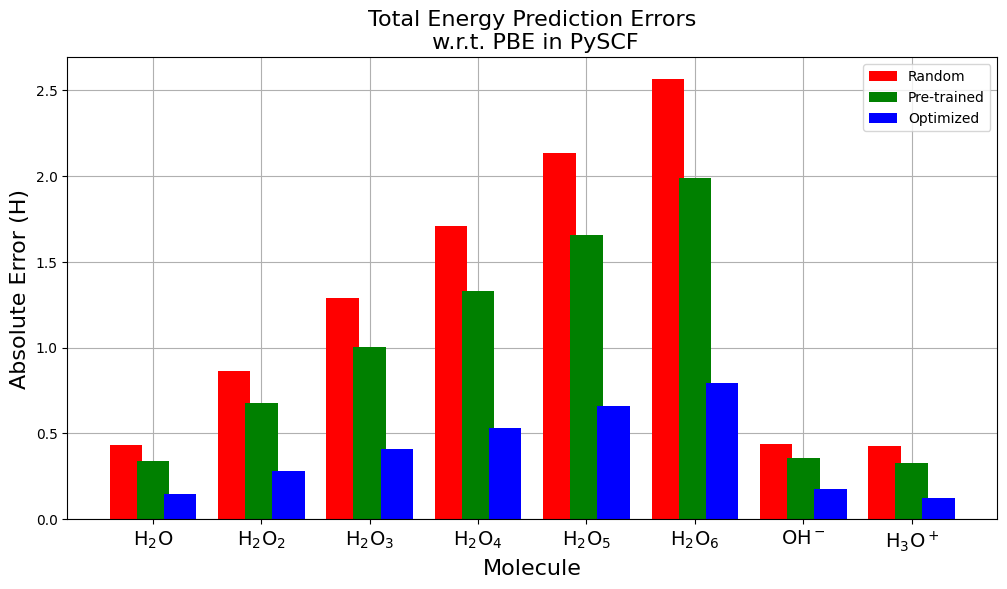

In [57]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
relevant_system_ticklabels = ['H$_2$O', 'H$_2$O$_2$', 'H$_2$O$_3$', 'H$_2$O$_4$', 'H$_2$O$_5$', 'H$_2$O$_6$', 'OH$^-$', 'H$_3$O$^+$']

ax.set_xticks(np.arange(1, len(relevant_systems)+2), labels=relevant_system_ticklabels+[''], fontsize=14)

for idx, sys in enumerate(relevant_systems):
    ran_err = abs(pbe_ens[sys][0]-ran_ens[sys][0])
    pre_err = abs(pbe_ens[sys][0]-pre_ens[sys][0])
    opt_err = abs(pbe_ens[sys][0]-opt_ens[sys][0])
    if idx == 0:
        ax.bar( (idx+1)-0.25, ran_err, facecolor='r', width=0.3, label = 'Random')
        ax.bar( (idx+1), pre_err, facecolor='g', width=0.3, label='Pre-trained')
        ax.bar( (idx+1)+0.25, opt_err, facecolor='b', width=0.3, label='Optimized')
    else:
        ax.bar( (idx+1)-0.25, ran_err, facecolor='r', width=0.3)
        ax.bar( (idx+1), pre_err, facecolor='g', width=0.3)
        ax.bar( (idx+1)+0.25, opt_err, facecolor='b', width=0.3)
ax.set_axisbelow(True)
ax.grid()
ax.legend()
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (H)', fontsize=16)
ax.set_title('Total Energy Prediction Errors\n w.r.t. PBE in PySCF', fontsize=16)

In [58]:
relevant_reactions = [
    { 'systems' : ['H2O2', 'H2O'], 'stoichiometry' : [-1, 2], 'reference' : 4.974000 },
    { 'systems' : ['H2O3', 'H2O'], 'stoichiometry' : [-1, 3], 'reference' : 15.708000 },
    { 'systems' : ['H2O4', 'H2O'], 'stoichiometry' : [-1, 4], 'reference' : 27.353000 },
    { 'systems' : ['H2O5', 'H2O'], 'stoichiometry' : [-1, 5], 'reference' : 35.879000 },
    { 'systems' : ['H2O6', 'H2O'], 'stoichiometry' : [-1, 6], 'reference' : 45.988000 },
]


In [59]:
(pbe_ens['H2O2'][0]*-1 + pbe_ens['H2O'][0]*2)/0.0016

Array(10.4065325, dtype=float64)

Finding errors for -1H2O2 + 2H2O with reference 0.007926693227091634
Barriers:  0.016650452001016447 0.019759891997580326 0.0224199155931899 0.023833376837615106
Errors:  0.008723758773924813 0.011833198770488692 0.014493222366098265 0.01590668361052347
Finding errors for -1H2O3 + 3H2O with reference 0.025032669322709162
Barriers:  0.053830527432381814 0.06474573833253316 0.0740444439404655 0.07999024075959937
Errors:  0.028797858109672652 0.039713069009824006 0.04901177461775634 0.054957571436890215
Finding errors for -1H2O4 + 4H2O with reference 0.043590438247011955
Barriers:  0.11156961408812549 0.13165794879790838 0.14573848240394227 0.1596842514227319
Errors:  0.06797917584111354 0.08806751055089643 0.10214804415693032 0.11609381317571996
Finding errors for -1H2O5 + 5H2O with reference 0.057177689243027886
Barriers:  0.1492375009635225 0.17587587070022437 0.19312382596694988 0.21195442291627842
Errors:  0.09205981172049463 0.11869818145719649 0.135946136723922 0.15477673367325054


Text(0.5, 1.0, 'Reaction Energy Prediction Errors\n w.r.t. WATER27 Reference Values')

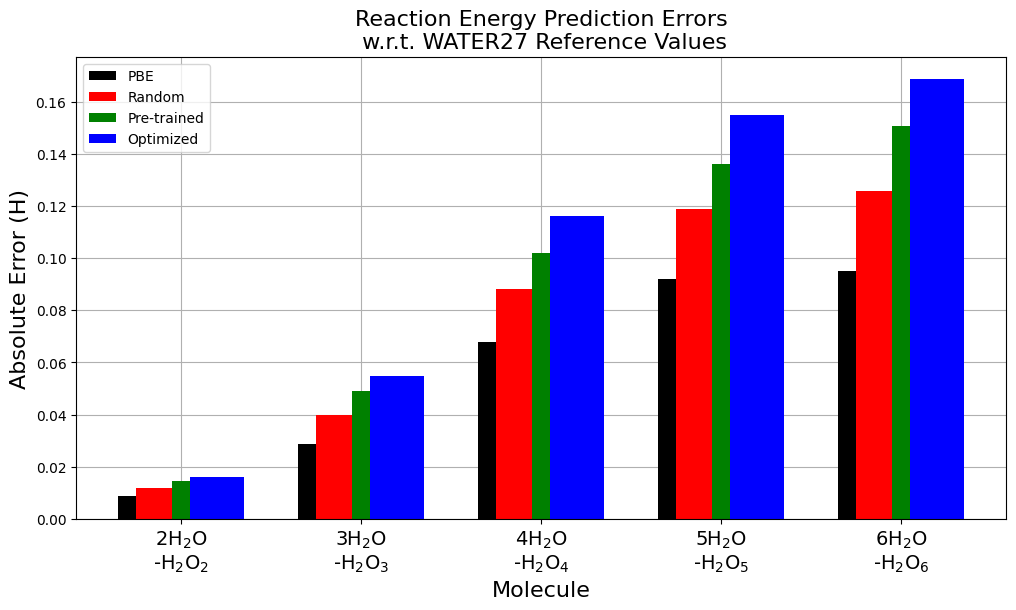

In [60]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
relevant_rxn_ticklabels = ['2H$_2$O\n-H$_2$O$_2$', '3H$_2$O\n-H$_2$O$_3$',
                           '4H$_2$O\n-H$_2$O$_4$', '5H$_2$O\n-H$_2$O$_5$',
                           '6H$_2$O\n-H$_2$O$_6$',]
ax.set_xticks(np.arange(1, len(relevant_reactions)+2), labels=relevant_rxn_ticklabels+[''], fontsize=14)

for idx, rxn in enumerate(relevant_reactions):
    sys1, h2o = rxn['systems']
    sys1mult, h2omult = rxn['stoichiometry']
    rxn_ref = rxn['reference']/627.5
    print('Finding errors for {}{} + {}{} with reference {}'.format(sys1mult,sys1,h2omult,h2o,rxn_ref))
    pbe_h = pbe_ens[sys1][0]*sys1mult + pbe_ens[h2o][0]*h2omult
    ran_h = ran_ens[sys1][0]*sys1mult + ran_ens[h2o][0]*h2omult
    pre_h = pre_ens[sys1][0]*sys1mult + pre_ens[h2o][0]*h2omult
    opt_h = opt_ens[sys1][0]*sys1mult + opt_ens[h2o][0]*h2omult
    print('Barriers: ', pbe_h, ran_h, pre_h, opt_h)
    pbe_err = abs(pbe_h - rxn_ref)
    ran_err = abs(ran_h - rxn_ref)
    pre_err = abs(pre_h - rxn_ref)
    opt_err = abs(opt_h - rxn_ref)
    print('Errors: ', pbe_err, ran_err, pre_err, opt_err)
    if idx == 0:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.3, label = 'PBE')
        ax.bar( (idx+1)-0.1, ran_err, facecolor='r', width=0.3, label='Random')
        ax.bar( (idx+1)+0.1, pre_err, facecolor='g', width=0.3, label='Pre-trained')
        ax.bar( (idx+1)+0.2, opt_err, facecolor='b', width=0.3, label='Optimized')
    else:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.3)
        ax.bar( (idx+1)-0.1, ran_err, facecolor='r', width=0.3)
        ax.bar( (idx+1)+0.1, pre_err, facecolor='g', width=0.3)
        ax.bar( (idx+1)+0.2, opt_err, facecolor='b', width=0.3)
ax.set_axisbelow(True)
ax.grid()
ax.legend()
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (H)', fontsize=16)
ax.set_title('Reaction Energy Prediction Errors\n w.r.t. WATER27 Reference Values', fontsize=16)

This is very bad and quite strange -- the total energy predictions get better across the board after training only on the water's total PBE energy, but these reaction barriers get worse the more training is done. So, let's optimize with a loss that trains on i) H2O and H2O2 and ii) it's WATER27 reference value.

In [61]:
rxnmols = []
rxnrefs = []
for idx, sys in enumerate(['H2O', 'H2O2']):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    rxnmols.append(mol)
    rxnrefs.append(pbe_ens[sys][0])
rxnrefs.append(0.007926693227091634)

H2O
H2O2


In [62]:
@eqx.filter_value_and_grad
def opt_loss_erxn(model, mols, refs):
    #in this very specific case, since len(mols) = 2 and len(refs) = 3, we can just use the last entry in refs to find the reaction loss
    #we aim for PBE total energies, but with rxn energy difference
    total_loss = 0
    energy_loss = 0
    rxn_loss = 0
    energies = {idx: 0 for idx in range(len(mols))}
    for idx, mol in enumerate(mols):
        # print(idx, mol)
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        energies[idx] = mf.e_tot
        energy_loss += abs(mf.e_tot - refs[idx])
    #here, we assume the ordering in mols is h2o then h2o2
    rxn_h = 2*energies[0] + (-1*energies[1])
    rxn_loss = abs(rxn_h - refs[-1])
    energy_loss /= len(mols)
    total_loss = rxn_loss+energy_loss
    return total_loss[..., jnp.newaxis][0]


@eqx.filter_value_and_grad
def opt_loss_erxn_10(model, mols, refs):
    #in this very specific case, since len(mols) = 2 and len(refs) = 3, we can just use the last entry in refs to find the reaction loss
    #we aim for PBE total energies, but with rxn energy difference
    total_loss = 0
    energy_loss = 0
    rxn_loss = 0
    energies = {idx: 0 for idx in range(len(mols))}
    for idx, mol in enumerate(mols):
        # print(idx, mol)
        mf = dft_ad.RKS(mol)
        custom_eval_xc = partial(eval_xc_gga_j2, xcmodel=model)
        mf.grids.level = 1
        mf.define_xc_(custom_eval_xc, 'GGA')
        mf.kernel()
        energies[idx] = mf.e_tot
        energy_loss += abs(mf.e_tot - refs[idx])
    #here, we assume the ordering in mols is h2o then h2o2
    rxn_h = 2*energies[0] + (-1*energies[1])
    rxn_loss = abs(rxn_h - refs[-1])
    energy_loss /= len(mols)
    total_loss = 10*rxn_loss+energy_loss
    return total_loss[..., jnp.newaxis][0]

In [63]:
opt_rxn_snmxc = Optimizer(model=test_model, optim=opt_opt, mols = rxnmols, refs = rxnrefs, loss=opt_loss_erxn, print_every=1, steps=50)
opt_rxn_snmxc_10 = Optimizer(model=test_model, optim=opt_opt, mols = rxnmols, refs = rxnrefs, loss=opt_loss_erxn_10, print_every=1, steps=50)

In [64]:
osnmxc_rxn, osnmxcl_rxn = opt_rxn_snmxc()

GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14),

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)


In [65]:
osnmxc_rxn_10, osnmxcl_rxn_10 = opt_rxn_snmxc_10()

GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)


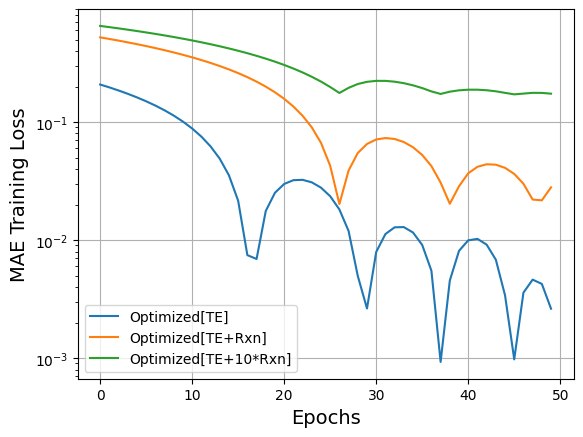

In [112]:
plt.plot(osnmxcl, label='Optimized[TE]')
plt.plot(osnmxcl_rxn, label='Optimized[TE+Rxn]')
plt.plot(osnmxcl_rxn_10, label='Optimized[TE+10*Rxn]')
plt.yscale('log')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MAE Training Loss', fontsize=14)
plt.grid()
plt.legend()

In [67]:
or_ens = {k: 0 for k in relevant_systems}
or10_ens = {k: 0 for k in relevant_systems}

In [68]:
for idx, sys in enumerate(relevant_systems):
    atstr = ''
    print(sys)
    for idx, at in enumerate(w27systems[sys]['atoms']):
        atstr += '{} {} {} {}\n'.format(at, *w27systems[sys]['coords'][idx])
    mol = gto_ad.Mole(atom = atstr, charge = w27systems[sys]['charge'], spin = w27systems[sys]['spin'])
    mol.build()
    mol.max_memory = 32000
    #baseline PBE calculation
    print('Optimized+reaction calculation...')
    or_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=osnmxc_rxn)
    mf_or = dft_ad.RKS(mol)
    mf_or.define_xc_(or_net_eval_xc, 'GGA')
    mf_or.grids.level = 1
    mf_or.kernel()
    or_ens[sys] = (mf_or.kernel(), mf_or.converged)
    print('Optimized+10reaction calculation...')
    or10_net_eval_xc = partial(eval_xc_gga_j2, xcmodel=osnmxc_rxn_10)
    mf_or10 = dft_ad.RKS(mol)
    mf_or10.define_xc_(or10_net_eval_xc, 'GGA')
    mf_or10.grids.level = 1
    mf_or10.kernel()
    or10_ens[sys] = (mf_or10.kernel(), mf_or10.converged)

H2O
Optimized+reaction calculation...
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)
v2 shape (8855, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 8855, 7), weight.shape=(8855,), coords.shape=(8855, 3)
(8855, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.shape=(17673,), coords.shape=(17673, 3)
(17673, 2)
v2 shape (17673, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 17673, 14), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.shape=(26160,), coords.shape=(26160, 3)
(26160, 2)
v2 shape (26160, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 26160, 21), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.shape=(34736,), coords.shape=(34736, 3)
(34736, 2)
v2 shape (34736, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 34736, 28), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.shape=(43498, 3)
(43498, 2)
v2 shape (43498, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 43498, 35), weight.shape=(43498,), coords.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.shape=(51314, 3)
(51314, 2)
v2 shape (51314, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 51314, 42), weight.shape=(51314,), coords.sha

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)
v2 shape (7688, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 7688, 6), weight.shape=(7688,), coords.shape=(7688, 3)
(7688, 2)


/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscfad/_src/util.py:108: UserWarning: Not taking derivatives wrt the leaves in the node <class 'pyscfad.dft.rks.VXC'> as none of those was specified.
  warnings.warn(f'Not taking derivatives wrt the leaves in '


v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(1265

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute coords because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute exp because it is not JSON-serializable
  warnings.warn(msg)
/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/gto/mole.py:1215: UserWarning: Function mol.dumps drops attribute ctr_coeff because it is not JSON-serializable
  warnings.warn(msg)


v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(12656,), coords.shape=(12656, 3)
(12656, 2)
v2 shape (12656, 2, 2)
GGA ni.block_loop; input ao.shape=(4, 12656, 8), weight.shape=(1265

Text(0.5, 1.0, 'Total Energy Prediction Errors\n w.r.t. PBE in PySCF')

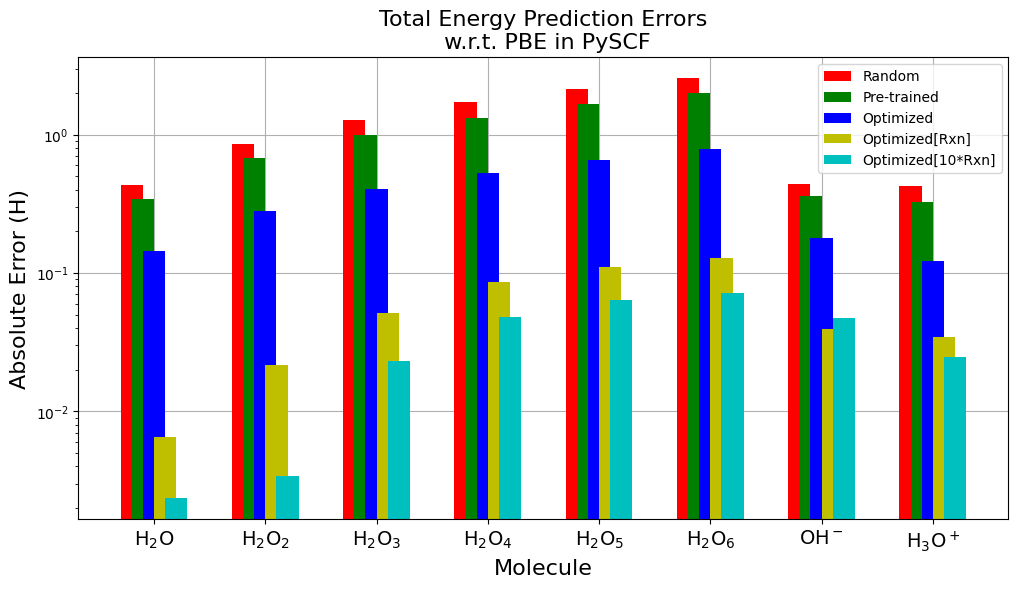

In [69]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
relevant_system_ticklabels = ['H$_2$O', 'H$_2$O$_2$', 'H$_2$O$_3$', 'H$_2$O$_4$', 'H$_2$O$_5$', 'H$_2$O$_6$', 'OH$^-$', 'H$_3$O$^+$']

ax.set_xticks(np.arange(1, len(relevant_systems)+2), labels=relevant_system_ticklabels+[''], fontsize=14)

for idx, sys in enumerate(relevant_systems):
    ran_err = abs(pbe_ens[sys][0]-ran_ens[sys][0])
    pre_err = abs(pbe_ens[sys][0]-pre_ens[sys][0])
    opt_err = abs(pbe_ens[sys][0]-opt_ens[sys][0])
    or_err = abs(pbe_ens[sys][0] - or_ens[sys][0])
    or10_err = abs(pbe_ens[sys][0] - or10_ens[sys][0])
    if idx == 0:
        ax.bar( (idx+1)-0.2, ran_err, facecolor='r', width=0.2, label = 'Random')
        ax.bar( (idx+1)-0.1, pre_err, facecolor='g', width=0.2, label='Pre-trained')
        ax.bar( (idx+1), opt_err, facecolor='b', width=0.2, label='Optimized[TE]')
        ax.bar( (idx+1)+0.1, or_err, facecolor='y', width=0.2, label='Optimized[TE+Rxn]')
        ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2, label='Optimized[TE+10*Rxn]')
    else:
        ax.bar( (idx+1)-0.2, ran_err, facecolor='r', width=0.2)
        ax.bar( (idx+1)-0.1, pre_err, facecolor='g', width=0.2)
        ax.bar( (idx+1), opt_err, facecolor='b', width=0.2)
        ax.bar( (idx+1)+0.1, or_err, facecolor='y', width=0.2)
        ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2)
ax.set_axisbelow(True)
ax.grid()
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (H)', fontsize=16)
ax.set_title('Total Energy Prediction Errors\n w.r.t. PBE in PySCF', fontsize=16)

Finding errors for -1H2O2 + 2H2O with reference 0.007926693227091634
Barriers:  0.016650452001016447 0.019759891997580326 0.0224199155931899 0.023833376837615106 0.025133138096151697
Errors:  0.008723758773924813 0.011833198770488692 0.014493222366098265 0.01590668361052347 0.016857962243619323
Finding errors for -1H2O3 + 3H2O with reference 0.025032669322709162
Barriers:  0.053830527432381814 0.06474573833253316 0.0740444439404655 0.07999024075959937 0.08527109626476204
Errors:  0.028797858109672652 0.039713069009824006 0.04901177461775634 0.054957571436890215 0.058993303024041974
Finding errors for -1H2O4 + 4H2O with reference 0.043590438247011955
Barriers:  0.11156961408812549 0.13165794879790838 0.14573848240394227 0.1596842514227319 0.17125687233442477
Errors:  0.06797917584111354 0.08806751055089643 0.10214804415693032 0.11609381317571996 0.12574148255424342
Finding errors for -1H2O5 + 5H2O with reference 0.057177689243027886
Barriers:  0.1492375009635225 0.17587587070022437 0.19

Text(0.5, 1.0, 'Reaction Energy Prediction Errors\n w.r.t. WATER27 Reference Values')

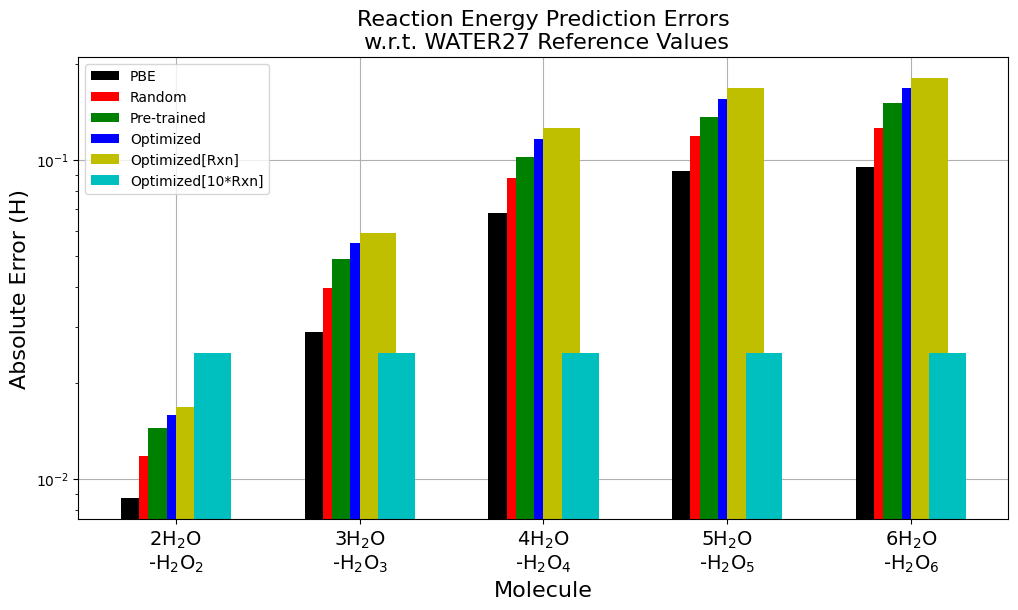

In [97]:
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
relevant_rxn_ticklabels = ['2H$_2$O\n-H$_2$O$_2$', '3H$_2$O\n-H$_2$O$_3$',
                           '4H$_2$O\n-H$_2$O$_4$', '5H$_2$O\n-H$_2$O$_5$',
                           '6H$_2$O\n-H$_2$O$_6$',]
ax.set_xticks(np.arange(1, len(relevant_reactions)+2), labels=relevant_rxn_ticklabels+[''], fontsize=14)

for idx, rxn in enumerate(relevant_reactions):
    sys1, h2o = rxn['systems']
    sys1mult, h2omult = rxn['stoichiometry']
    rxn_ref = rxn['reference']/627.5
    print('Finding errors for {}{} + {}{} with reference {}'.format(sys1mult,sys1,h2omult,h2o,rxn_ref))
    pbe_h = pbe_ens[sys1][0]*sys1mult + pbe_ens[h2o][0]*h2omult
    ran_h = ran_ens[sys1][0]*sys1mult + ran_ens[h2o][0]*h2omult
    pre_h = pre_ens[sys1][0]*sys1mult + pre_ens[h2o][0]*h2omult
    opt_h = opt_ens[sys1][0]*sys1mult + opt_ens[h2o][0]*h2omult
    or_h = or_ens[sys1][0]*sys1mult + or_ens[h2o][0]*h2omult
    or10_h = or10_ens[sys1][0]*sys1mult + or10_ens[h2o][0]*h2omult
    print('Barriers: ', pbe_h, ran_h, pre_h, opt_h, or_h)
    pbe_err = abs(pbe_h - rxn_ref)
    ran_err = abs(ran_h - rxn_ref)
    pre_err = abs(pre_h - rxn_ref)
    opt_err = abs(opt_h - rxn_ref)
    or_err = abs(or_h - rxn_ref)
    or_err = abs(or10_h - rxn_ref)
    print('Errors: ', pbe_err, ran_err, pre_err, opt_err, or_err)
    if idx == 0:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2, label = 'PBE')
        ax.bar( (idx+1)-0.1, ran_err, facecolor='r', width=0.2, label='Random')
        ax.bar( (idx+1)-0.05, pre_err, facecolor='g', width=0.2, label='Pre-trained')
        ax.bar( (idx+1)+0.05, opt_err, facecolor='b', width=0.2, label='Optimized[TE]')
        ax.bar( (idx+1)+0.1, or_err, facecolor='y', width=0.2, label='Optimized[TE+Rxn]')
        ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2, label='Optimized[TE+10*Rxn]')
    else:
        ax.bar( (idx+1)-0.2, pbe_err, facecolor='k', width=0.2)
        ax.bar( (idx+1)-0.1, ran_err, facecolor='r', width=0.2)
        ax.bar( (idx+1)-0.05, pre_err, facecolor='g', width=0.2)
        ax.bar( (idx+1)+0.05, opt_err, facecolor='b', width=0.2)
        ax.bar( (idx+1)+0.1, or_err, facecolor='y', width=0.2)
        ax.bar( (idx+1)+0.2, or10_err, facecolor='c', width=0.2)
ax.set_axisbelow(True)
ax.grid()
ax.legend()
ax.set_xlabel('Molecule', fontsize=16)
ax.set_ylabel('Absolute Error (H)', fontsize=16)
ax.set_yscale('log')
ax.set_title('Reaction Energy Prediction Errors\n w.r.t. WATER27 Reference Values', fontsize=16)